<h1> Visualize Signal and BG PDF for profile likelihood </h1>

In [6]:
from __future__ import division
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') 
from pyROOT_import import *
from pyNEST import *
from ROOT import TH2D
import scipy as spy
import scipy.stats as stats
from scipy.interpolate import interp2d
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
#plt.rc('text', usetex=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> WS cuts </h1>

In [2]:
#WS cuts
S1_min=0
S1_max=20
S2raw_min=450
#NS1_coin_req=3

#define. calc LZ  nominal exposure
def calc_exposure(S1_cut, S2_cut, S1_win_max=20):
    LZ_count=sum(S1_cut<S1_win_max)/Det_exposure_factor
    LZ_count_underNr=sum((S1_cut<S1_win_max) & (log10(S2_cut/S1_cut)<sNR(S1_cut)))/Det_exposure_factor
    sig_LZ_count=sqrt(sum(S1_cut<S1_win_max))/Det_exposure_factor
    sig_LZ_count_underNr=sqrt(sum((S1_cut<20) & (log10(S2_cut/S1_cut)<sNR(S1_cut))))/Det_exposure_factor
    print('Count (0 to '+str(S1_win_max) + ' S1) = '+'{:.3f}'.format(LZ_count) + ' +/- ' + '{:.3f}'.format(sig_LZ_count) )
    print('Count below NR mean (0 to '+str(S1_win_max) + ' S1) = '+'{:.3f}'.format(LZ_count_underNr) + ' +/- ' + '{:.3f}'.format(sig_LZ_count_underNr) )

<h1> Generate ER and NR bands </h1>

In [4]:
##############################################################################
#Generate Flat ER and 50 GeV WIMP NR spectra:
##############################################################################
#LZ
NEST =NEST_setup(Det='LZ', nFold=3, g1=0.075, e_lifetime=850, eff_extract=0.95, custom=True)
S1_bin_cen_n, mean_S2oS1_n, std_S2oS1_n, S1_bin_cen_e, mean_S2oS1_e, std_S2oS1_e, E_bin_cen_e,\
Eff_e, E_bin_cen_n, Eff_n,num_leak_e, num_total_e, leak_gauss_e, sNR = \
genBands(NEST=NEST,S2raw_min=450,nSim=1e6,mWmp=50)

#get NR mean, with a smooth spline
#sNR = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n,s=.005)

#calculate NR ER discrimination
leak_cut=(S1_bin_cen_e>1) & (S1_bin_cen_e<20)
discrim=100*(1-sum(num_leak_e[leak_cut])/sum(num_total_e[leak_cut]))
discrim

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: LCE (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: EField (Potential memory leak).
/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/adobi/iPyNb/NERSC_Import/pyNEST.py:279: RuntimeWarning: invalid value encountered in long_scalars
  Eff_n[index]=sum(cut)/sum(inrange(Er,[Es-0.5,Es+0.5])) #cut/total_in_bin


99.700086139882771

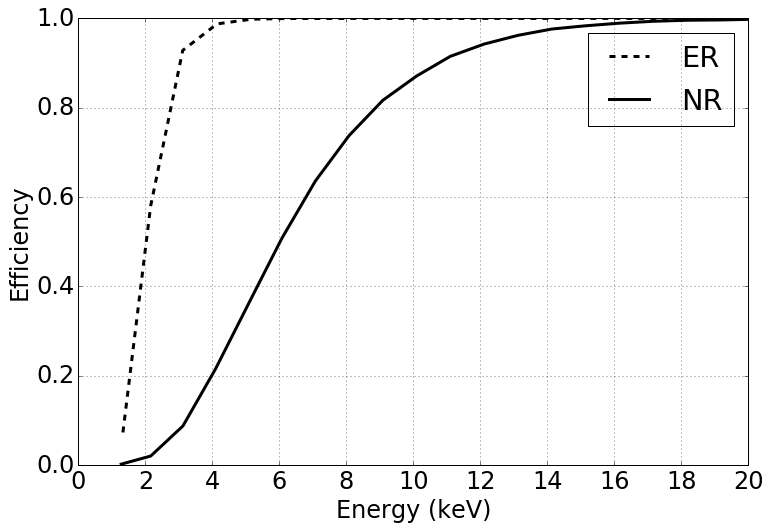

In [9]:
plt.plot(E_bin_cen_e,Eff_e,'--k',linewidth=3,label='ER')
plt.plot(E_bin_cen_n,Eff_n,'k',linewidth=3,label='NR')
xlim([0,20])
xlabel('Energy (keV)')
ylabel('Efficiency')
xticks(np.arange(0,21,2))
legend()
grid()

savefig('figs/Threshold.png',dpi=200)
savefig('figs/Threshold.pdf')

<h1> ATM nu PDF </h1>

total between 1.00 and 100.00 keV = 1.45162e-07 [evts/kg/day]
Detector exposure factor = 24603.1
Count (0 to 20 S1) = 0.436 +/- 0.004
Count below NR mean (0 to 20 S1) = 0.191 +/- 0.003


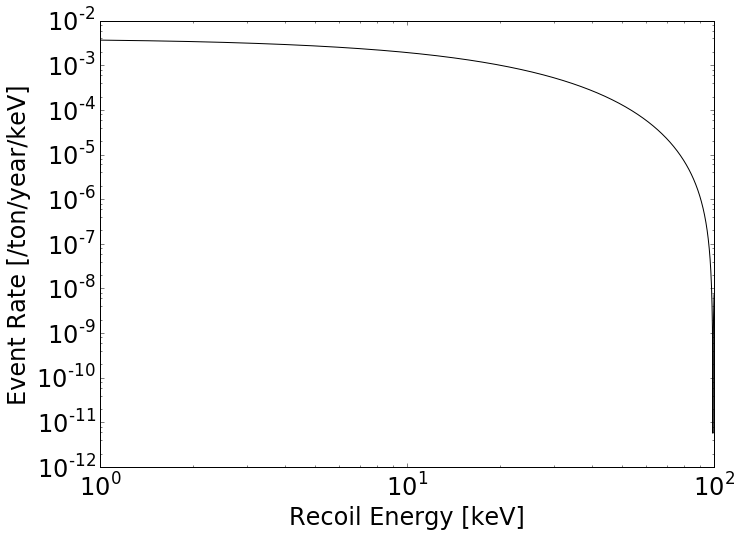

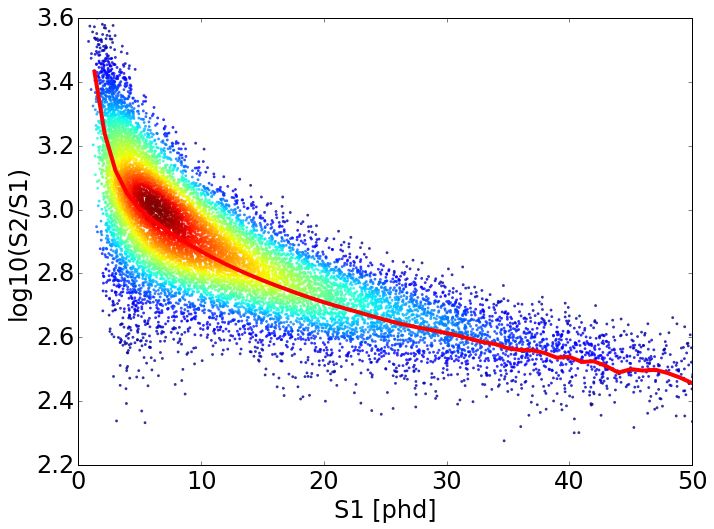

In [141]:
# ATM nu PDF
file_path='data/atm_Peter_update.txt' #caught a 2x error in rate
title='ATM'
ParticleType=0 #'NR'
nSim=2e4
NEST.SetParticleType(ParticleType)
Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
#plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_atm=S1c[rnd_index]
S2_atm=S2c[rnd_index]
S2_atm_raw=S2[rnd_index]

<h1> B8 nu PDF </h1>

total between 1.00 and 4.40 keV = 0.000260662 [evts/kg/day]
Detector exposure factor = 685.069
Count (0 to 20 S1) = 2.306 +/- 0.058
Count below NR mean (0 to 20 S1) = 2.305 +/- 0.058


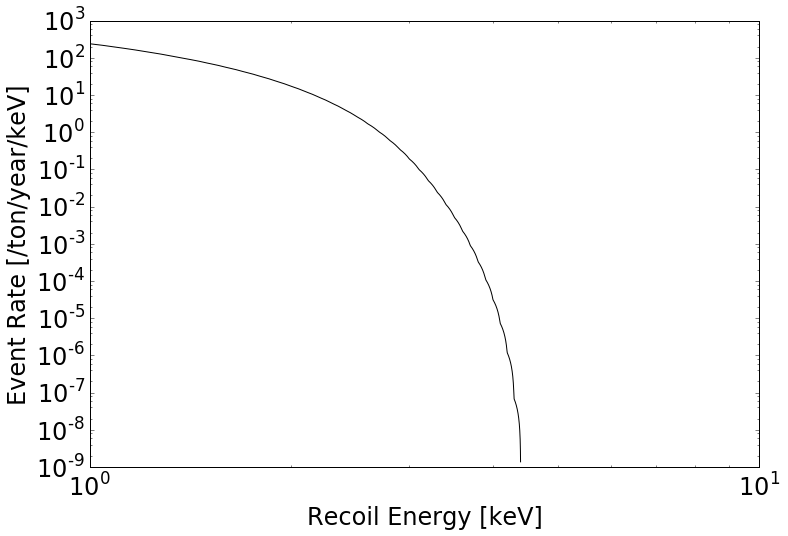

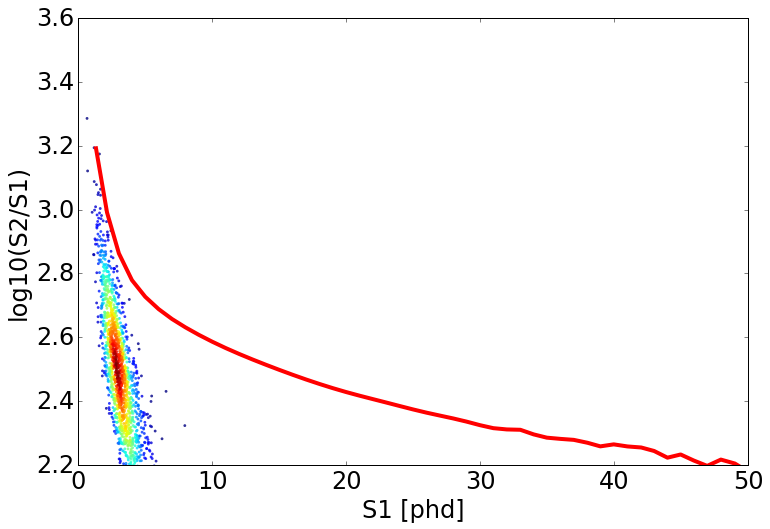

In [8]:
# B8 nu PDF
file_path='data/B8_Peter.txt' #caught a 2x error in rate
title='B8'
ParticleType=0 #'NR'
nSim=1e6

NEST.SetParticleType(ParticleType)
Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]

S1_cut_b8=S1_cut
S2_cut_b8=S2_cut
b8_exp=Det_exposure_factor

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
#plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

#pick events, for later use with LZ exposure plot
rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_b8=S1c[rnd_index]
S2_b8=S2c[rnd_index]
S2_b8_raw=S2[rnd_index]

<h1> HEP nu PDF </h1>

total between 0.10 and 5.80 keV = 6.32879e-06 [evts/kg/day]
Detector exposure factor = 56431.5
Count (0 to 20 S1) = 0.232 +/- 0.002
Count below NR mean (0 to 20 S1) = 0.231 +/- 0.002


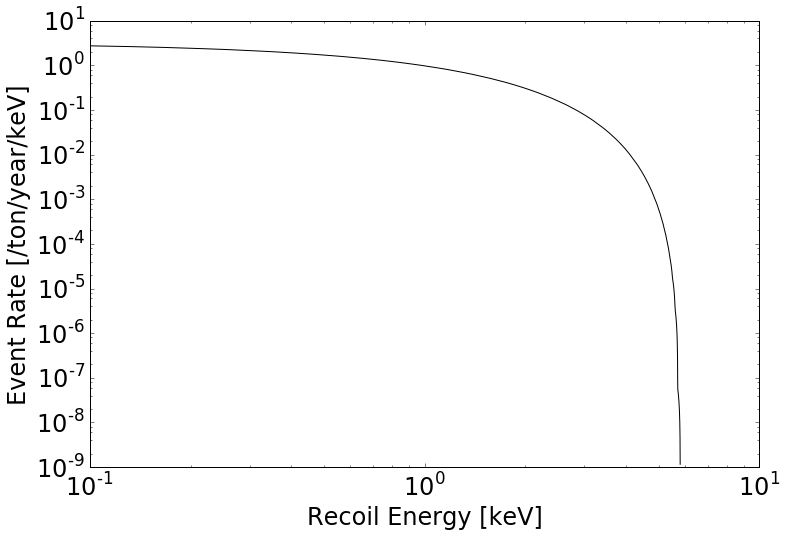

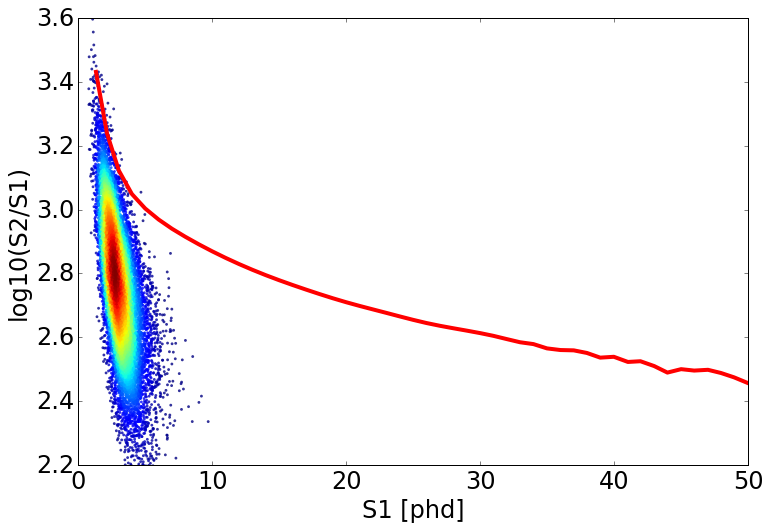

In [6]:
# HEP nu PDF
file_path='data/hep_Peter.txt' #caught a 2x error in rate
title='HEP'
ParticleType=0 #'NR'
nSim=2e6

NEST.SetParticleType(ParticleType)
Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
#plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_hep=S1c[rnd_index]
S2_hep=S2c[rnd_index]
S2_hep_raw=S2[rnd_index]

<h1> DSN nu PDF </h1>

total between 0.10 and 118.35 keV = 1.21975e-07 [evts/kg/day]
Detector exposure factor = 73199.8
Count (0 to 20 S1) = 0.089 +/- 0.001
Count below NR mean (0 to 20 S1) = 0.057 +/- 0.001


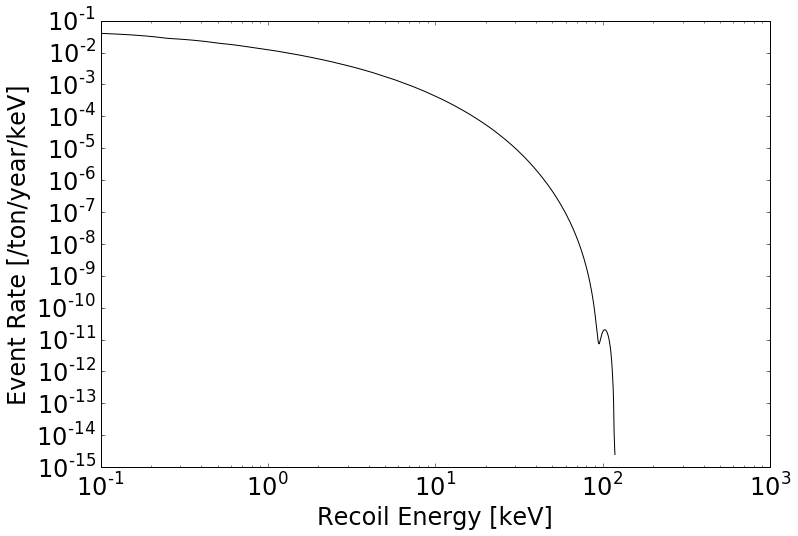

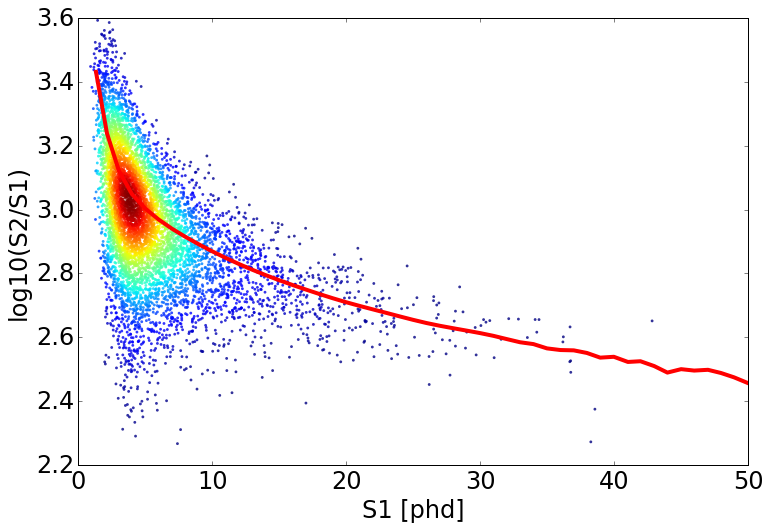

In [7]:
# DSN nu PDF
file_path='data/DSN_DiffRate.txt' #caught a 2x error in rate
title='DSN'
ParticleType=0 #'NR'
nSim=5e4

NEST.SetParticleType(ParticleType)
Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
#plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_dsn=S1c[rnd_index]
S2_dsn=S2c[rnd_index]
S2_dsn_raw=S2[rnd_index]

<h1> PP + 7 Be </h1>

total between 0.00 and 200.00 keV = 0.0012663 [evts/kg/day]
Detector exposure factor = 14.1018
Count (0 to 20 S1) = 309.110 +/- 4.682
Count below NR mean (0 to 20 S1) = 1.702 +/- 0.347


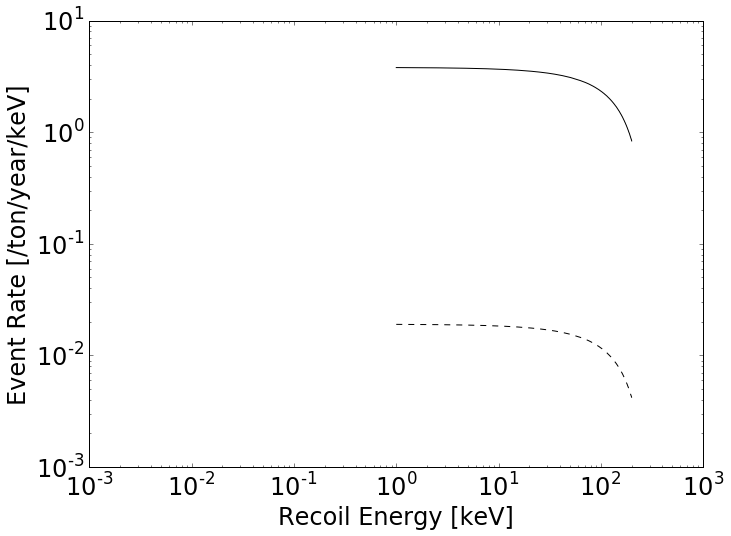

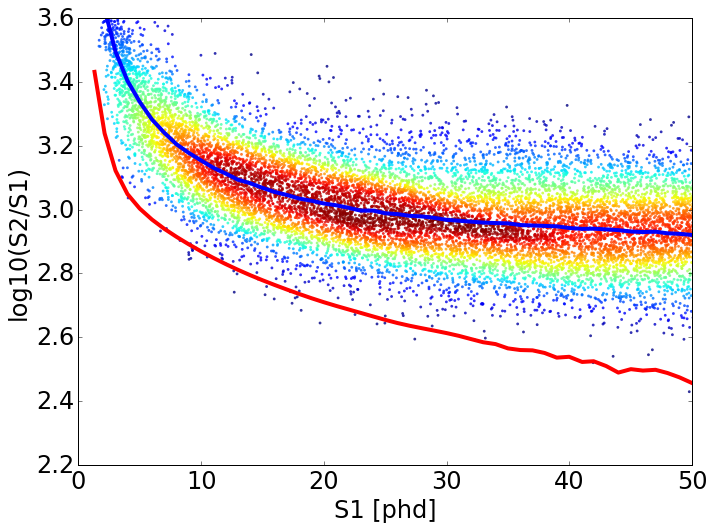

In [112]:
# PP nu PDF
file_path='data/PPsolarNu_Peter.txt' #caught a 2x error in rate
title='PP'
ParticleType=1 #'ER'
nSim=1e5

NEST.SetParticleType(ParticleType)
Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min) & (S1c<60)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]

S1_cut_pp=S1_cut
S2_cut_pp=S2_cut
pp_rate=Rate_evts_kg_day
pp_exp=Det_exposure_factor

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_pp=S1c[rnd_index]
S2_pp=S2c[rnd_index]
S2_pp_raw=S2[rnd_index]

<h1> Rn222 </h1>

total between 0.10 and 100.00 keV = 0.00278915 [evts/kg/day]
Detector exposure factor = 10.0037
Count (0 to 20 S1) = 856.585 +/- 9.253
Count below NR mean (0 to 20 S1) = 2.399 +/- 0.490


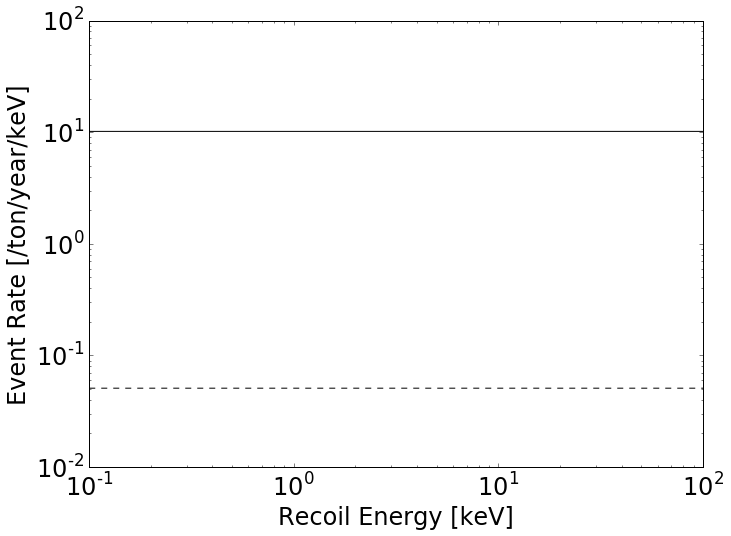

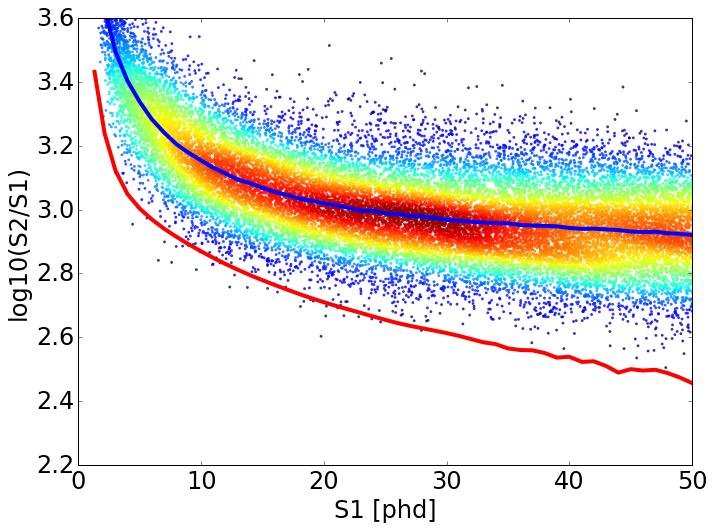

In [113]:
title='Rn222'
NEST.SetParticleType(1)
nSim=10/6.4*1e5 #make 10x LZ exposoure

#scale factor c. LZ has 2 uBq/kg total and 3.57 in the fid
c=1*1.91*(9.2/6.3) # LZ fiducial with 1.91 uBq/kg in the active volume
Eee=np.linspace(0.1,100,2e3) # to 100 keV
Rn222 = c*3.65*ones(size(Eee))# (0.01 DRU per mBq/kg) #3.65 evts/keV/ton/year per 1 uBq/kg ... now LZ has 2 uBq/kg total
dR = Rn222 #evts/keV/ton/year

np.savetxt('data/Rn222_LZ_fid.txt' ,np.vstack([Eee, dR]).T)
file_path='data/Rn222_LZ_fid.txt'

Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min) & (S1c<60) #last cut is to speed up plotting
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]
rn_rate=Rate_evts_kg_day
rn_exp=Det_exposure_factor

S1_cut_rn=S1_cut
S2_cut_rn=S2_cut

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_Rn=S1c[rnd_index]
S2_Rn=S2c[rnd_index]
S2_Rn_raw=S2[rnd_index]

<h1> Rn220 </h1>

total between 0.10 and 100.00 keV = 0.000457238 [evts/kg/day]
Detector exposure factor = 39.0544
Count (0 to 20 S1) = 139.600 +/- 1.891
Count below NR mean (0 to 20 S1) = 0.538 +/- 0.117


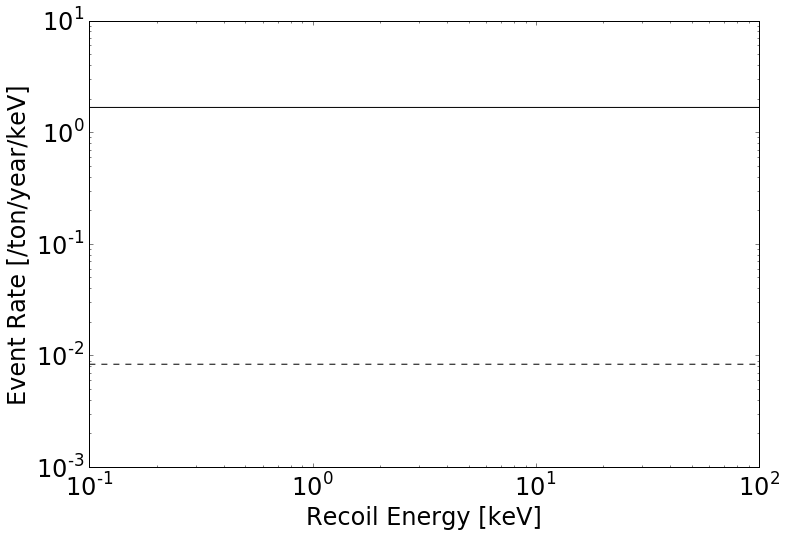

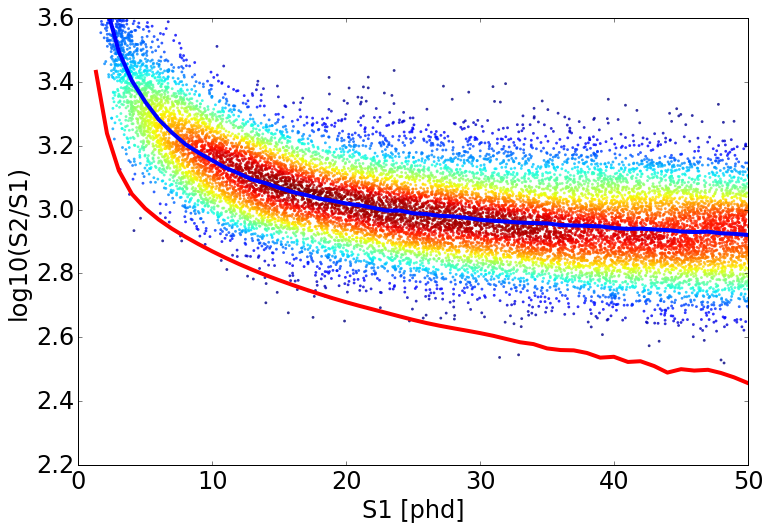

In [10]:
title='Rn220'
NEST.SetParticleType(1)
nSim=1e5

#scale factor c. LZ has 2 uBq/kg total and 3.57 in the fid
c=1*1.91*(9.2/6.3)*1/6.1 # LZ fiducial with 2 uBq/kg
Eee=np.linspace(0.1,100,2e3) # to 100 keV
Rn222 = c*3.65*ones(size(Eee))# (0.01 DRU per mBq/kg) #3.65 evts/keV/ton/year per 1 uBq/kg ... now LZ has 2 uBq/kg total
dR = Rn222 #evts/keV/ton/year

np.savetxt('data/Rn220_LZ_fid.txt' ,np.vstack([Eee, dR]).T)
file_path='data/Rn220_LZ_fid.txt'

Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min) & (S1c<60)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]
rn220_rate=Rate_evts_kg_day
rn220_exp=Det_exposure_factor

S1_cut_rn220=S1_cut
S2_cut_rn220=S2_cut


#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor))
S1_Rn220=S1c[rnd_index]
S2_Rn220=S2c[rnd_index]
S2_Rn220_raw=S2[rnd_index]

<h1> Paolo NR BG </h1>

total between 1.00 and 199.00 keV = 1.40141e-07 [evts/kg/day]
Detector exposure factor = 12742.3
Count (0 to 20 S1) = 0.335 +/- 0.005
Count below NR mean (0 to 20 S1) = 0.142 +/- 0.003


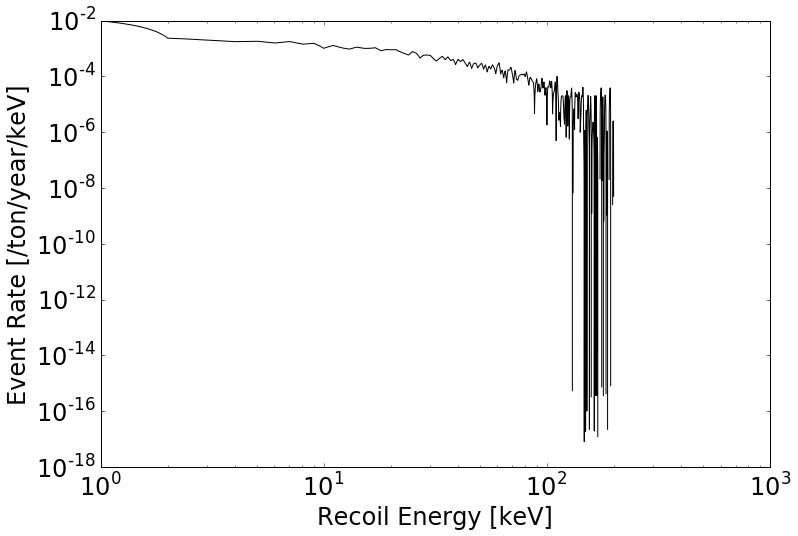

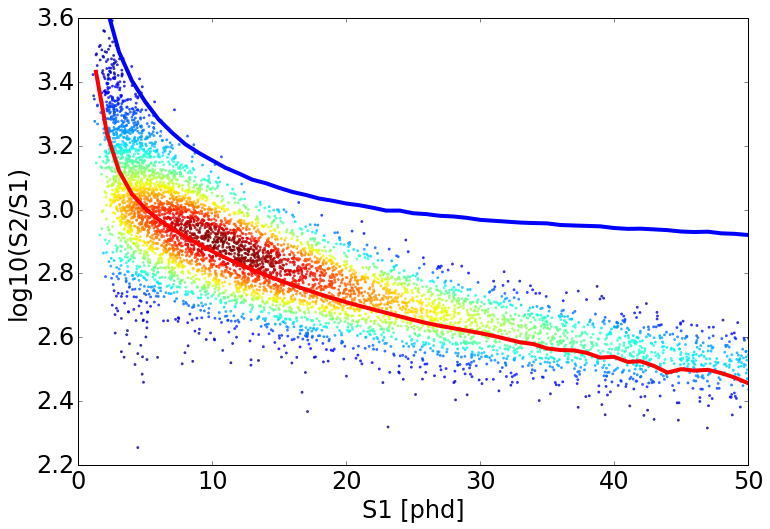

In [11]:
title='Paolo_NR'
file_path='data/rate_nr_fidvol.txt' 
ParticleType=0 #'NR'
nSim=1e4

NEST.SetParticleType(ParticleType)
Er, Nph, Ne, S1, S2, S1c, S2c, Rate_evts_kg_day, Det_exposure_factor = dN2S1S2(NEST=NEST, file_path=file_path, nSim=nSim)

WS_cut=(S1c>0) & (S2>=S2raw_min)
S1_cut=S1c[WS_cut]
S2_cut=S2c[WS_cut]

#make a scatter plot
plt.figure()
scatterColor(S1_cut,log10(S2_cut/S1_cut))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
plot(S1_bin_cen_n,mean_S2oS1_e,'-b',linewidth=4)
plt.xlim([0,50])
plt.ylim([2.2,3.6])

savefig('figs/'+title+'_S2S1.png')

#calc LZ  nominal exposure
calc_exposure(S1_cut, S2_cut)

rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/Det_exposure_factor*2))
S1_Nr=S1c[rnd_index]
S2_Nr=S2c[rnd_index]
S2_Nr_raw=S2[rnd_index]

<h1> Generate WIMP signal </h1>

total rate above 0.00 keV = 749851 [evts/kg/day per pb]
Detector exposure factor per pb = 4.76285e-08
total rate above 0.00 keV = 1.09433e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 1.30543e-08
total rate above 0.00 keV = 1.08837e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 1.64072e-08
total rate above 0.00 keV = 1.02041e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 3.49998e-09
total rate above 0.00 keV = 679104 [evts/kg/day per pb]
Detector exposure factor per pb = 5.25903e-09
total rate above 0.00 keV = 80928.7 [evts/kg/day per pb]
Detector exposure factor per pb = 4.41306e-08


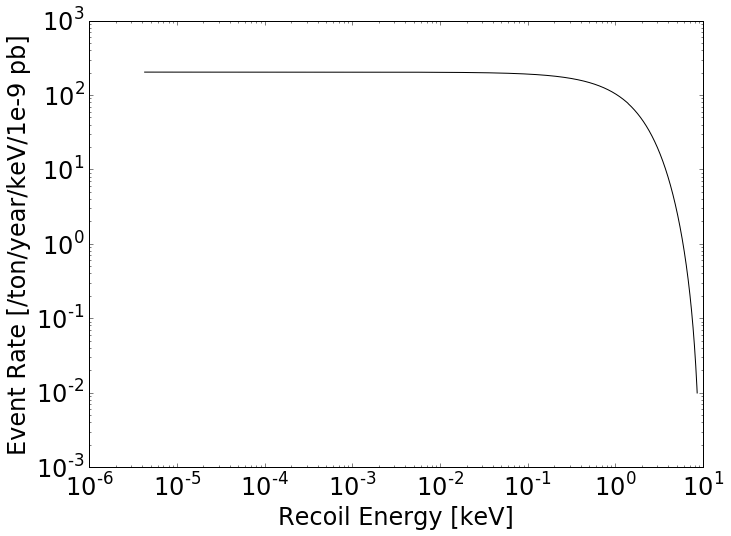

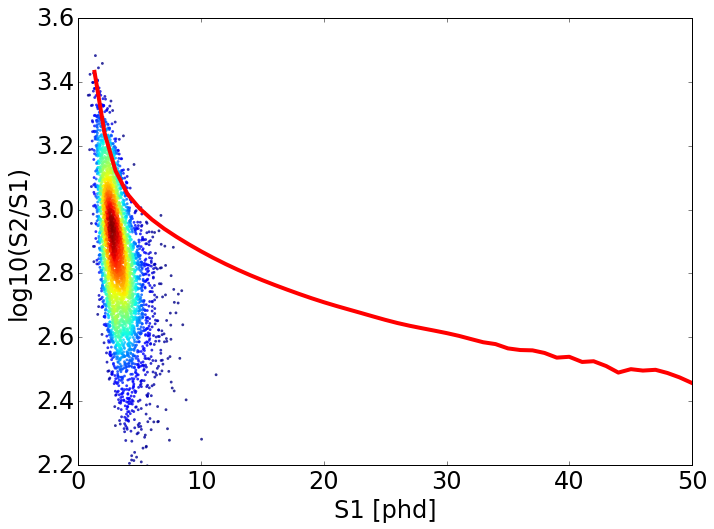

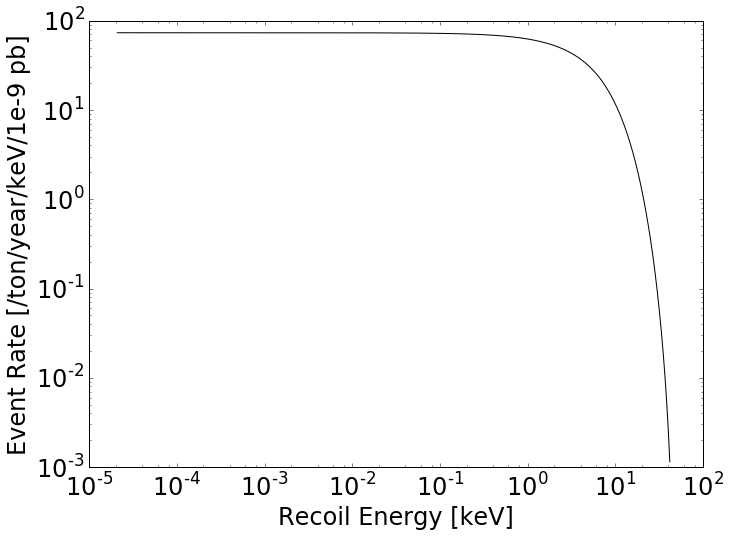

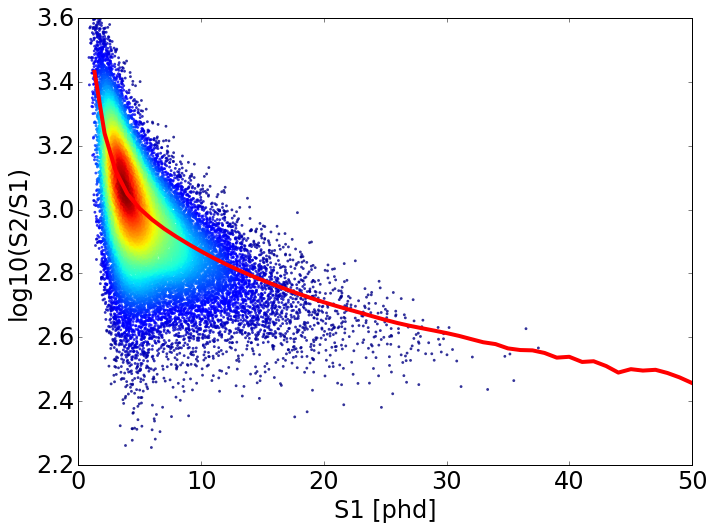

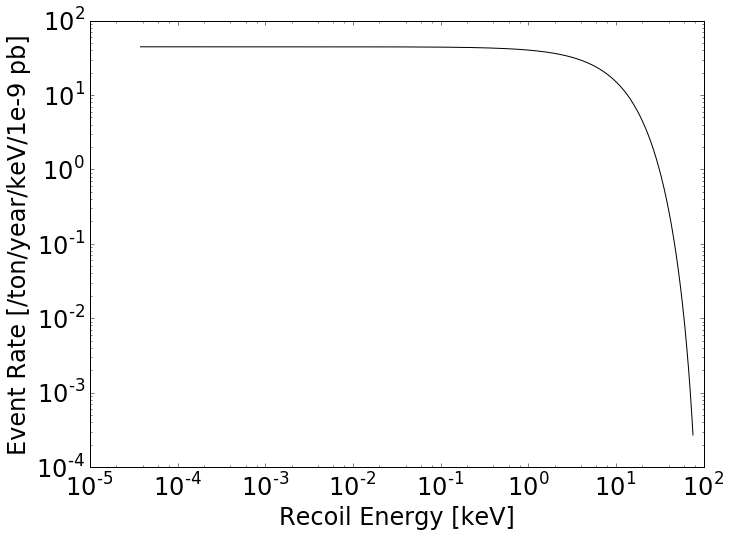

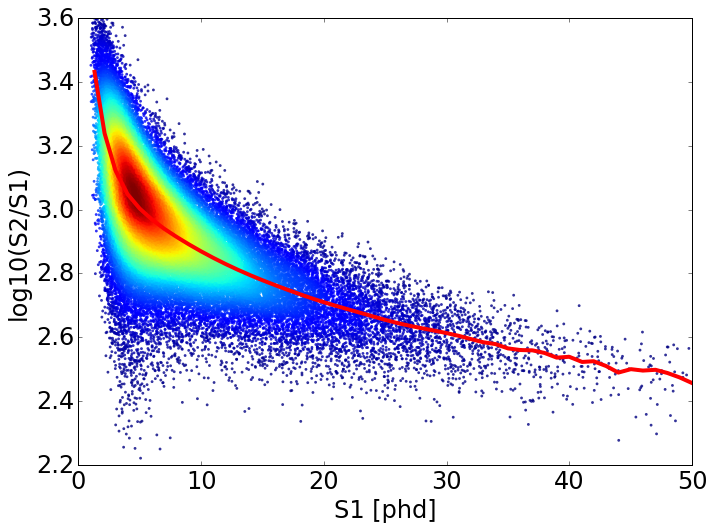

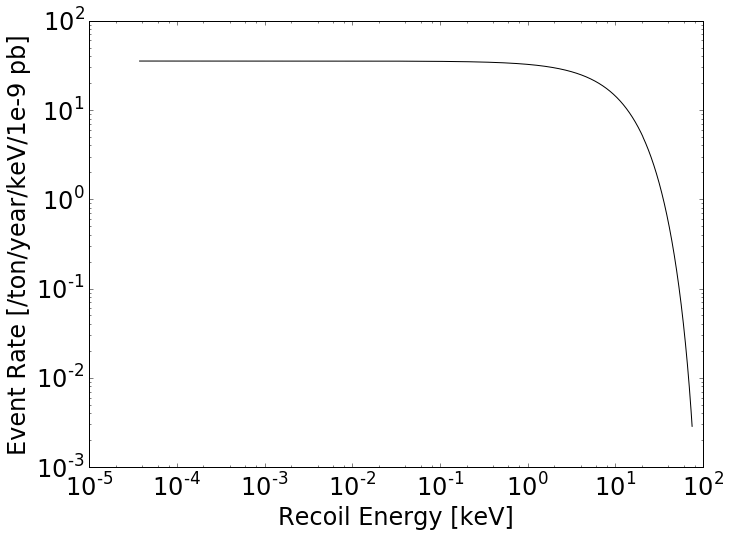

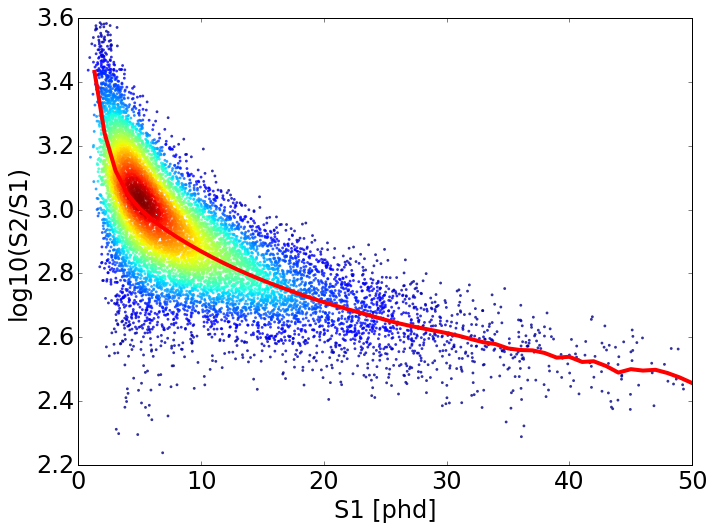

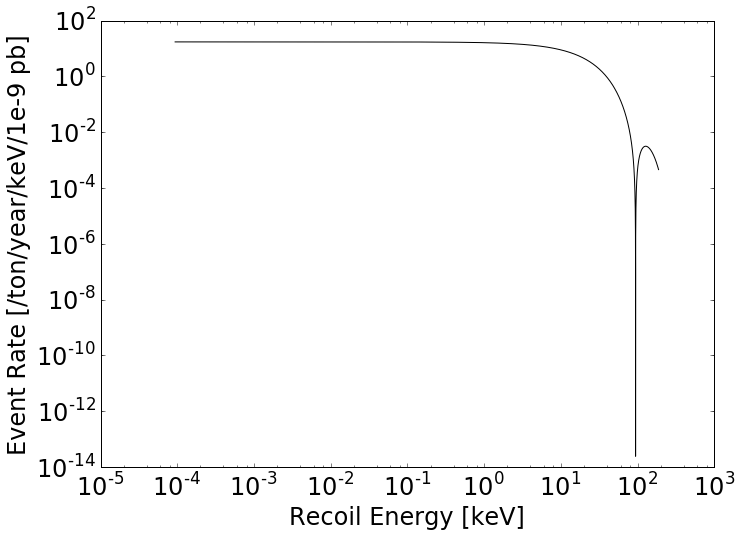

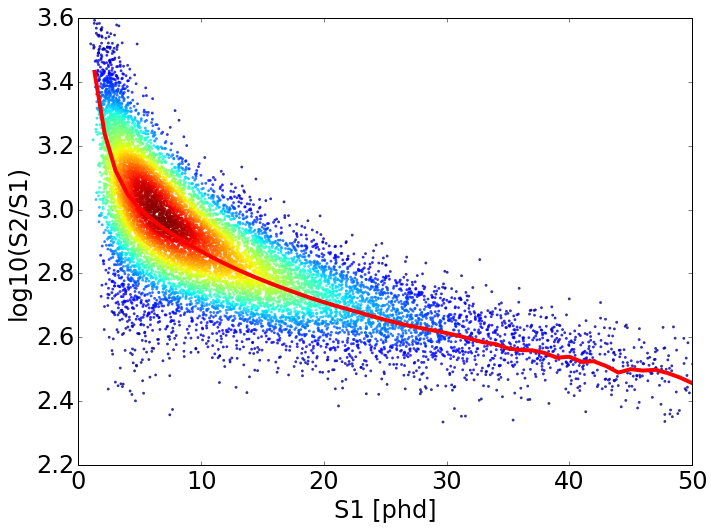

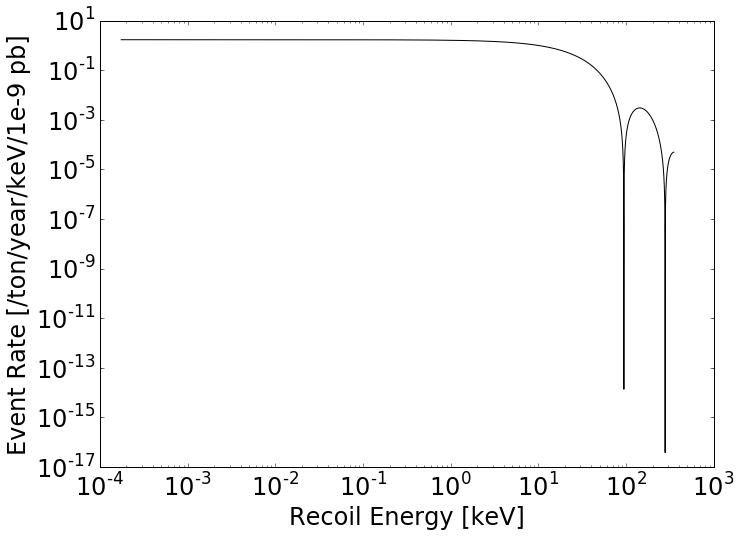

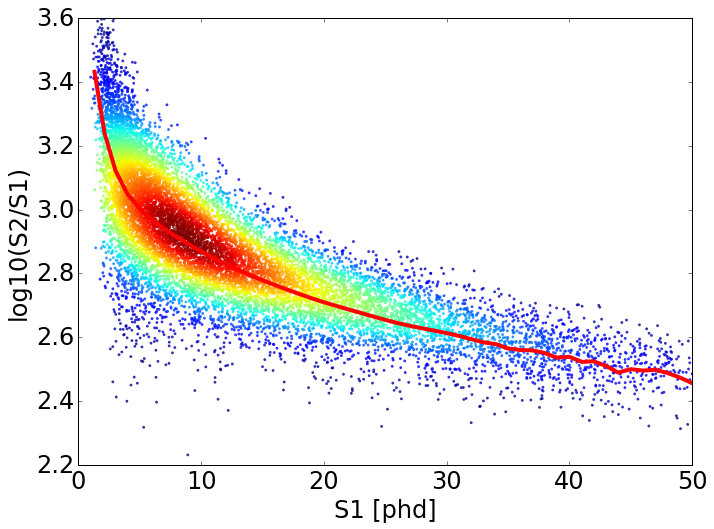

In [118]:
S2raw_min=450
nSim=1e5
NEST.SetParticleType(0) #0=NR

#Generate WIMPs
for mWmp,nSim in zip(int32([10,25, 40, 50,100, 1000]),int32([2e5,8e4,1e5,2e4,2e4,2e4])): #was 4e4 for mW=50
    Er, Nph, Ne, S1, S2, S1c, S2c, WmpRate, Det_exposure_factor=WIMP2NphNe(NEST=NEST,mWmp=mWmp,nSim=nSim)
    # 1e-45 cm^2 cross section
    title='WIMP_M'+str(mWmp)

    WS_cut=(S1c>0) & (S2>=S2raw_min)
    S1_cut=S1c[WS_cut]
    S2_cut=S2c[WS_cut]

    #make a scatter plot
    plt.figure()
    scatterColor(S1_cut,log10(S2_cut/S1_cut))
    plt.xlabel('S1 [phd]')
    plt.ylabel('log10(S2/S1)')
    plt.rcParams.update({'font.size': 24})
    #plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
    #plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)
    plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
    plt.xlim([0,50])
    plt.ylim([2.2,3.6])
    savefig('figs/'+title+'_S2S1.png')
    
    if mWmp==1000:
        rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/(Det_exposure_factor/1e-11))) #for a 1e-47 cross-section. 1e-9/100
        S1_mw1000=S1c[rnd_index]
        S2_mw1000=S2c[rnd_index]
        S2_mw1000_raw=S2[rnd_index]
        S1_cut_mw1000=S1_cut
        S2_cut_mw1000=S2_cut
        mw1000_exp_sig47=Det_exposure_factor/1e-11
    if mWmp==50:
        rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/(Det_exposure_factor/1e-11))) #for a 1e-47 cross-section. 1e-9/100
        S1_mw50=S1c[rnd_index]
        S2_mw50=S2c[rnd_index]
        S2_mw50_raw=S2[rnd_index]
        S1_cut_mw50=S1_cut
        S2_cut_mw50=S2_cut
        mw50_exp_sig47=Det_exposure_factor/1e-11
    if mWmp==40:
        rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/(Det_exposure_factor/1e-11))) #for a 1e-47 cross-section. 1e-9/100
        S1_mw40=S1c[rnd_index]
        S2_mw40=S2c[rnd_index]
        S2_mw40_raw=S2[rnd_index]
        S1_cut_mw40=S1_cut
        S2_cut_mw40=S2_cut
        mw40_exp_sig47=Det_exposure_factor/1e-11
    if mWmp==10:
        rnd_index=np.random.choice(np.arange(0,len(S1c)),int(nSim/(Det_exposure_factor/1e-11))) #for a 1e-47 cross-section. 1e-9/100
        S1_mw10=S1c[rnd_index]
        S2_mw10=S2c[rnd_index]
        S2_mw10_raw=S2[rnd_index]
        S1_cut_mw10=S1_cut
        S2_cut_mw10=S2_cut
        mw10_exp_sig47=Det_exposure_factor/1e-11


<h1> Contour Plot. 8B, ER (Rn+PP), WIMP 50 GeV </h1>

In [115]:
#normalize relative to Rn exposure
maxpp=int(size(S1_cut_pp)*rn_exp/pp_exp)
maxrn220=int(size(S1_cut_rn220)*rn_exp/rn220_exp)
maxb8=int(size(S1_cut_b8)*rn_exp/b8_exp)

S1_cut_er=hstack((S1_cut_pp[0:maxpp],S1_cut_rn,S1_cut_rn220[0:maxrn220]))
S2_cut_er=hstack((S2_cut_pp[0:maxpp],S2_cut_rn,S1_cut_rn220[0:maxrn220]))

#add 8B to backgrounds
#S1_cut_er=hstack((S1_cut_pp[0:maxpp],S1_cut_rn,S1_cut_rn220[0:maxrn220],S1_cut_b8[0:maxb8]))
#S2_cut_er=hstack((S2_cut_pp[0:maxpp],S2_cut_rn,S1_cut_rn220[0:maxrn220],S2_cut_b8[0:maxb8]))

total_er_rate=pp_rate+rn_rate+rn220_rate
er_exp=(pp_exp*pp_rate+rn_exp*rn_rate+rn220_exp*rn220_rate)/total_er_rate

#pdfcont(S1_cut_er,log10(S2_cut_er/S1_cut_er),color='b',nsig=2)
#pdfcont(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8),color='r',nsig=2)
#pdfcont(S1_cut_wm50,log10(S2_cut_wm50/S1_cut_wm50),color='m',nsig=2)
#xlim(1,50)
#xscale('log')
#savefig('figs/Contour.pdf')

<h1> Make multivariate discriminant plot </h1>

In [105]:
x_range_sel=[0, 50]
y_range_sel=[1.0,4.0]
pdf_er, x_er, y_er, xx, yy= pdf_gen(S1_cut_er, log10(S2_cut_er/S1_cut_er),x_range_sel,y_range_sel)

NEST.SetParticleType(0) #0=NR
listW=[]
listEr=[]
#Generate WIMPs
for mWmp in [10, 15, 20, 25, 30, 40,50,100,1000]:
    if mWmp<10:
        nSim=1e8
        bins=50
    elif mWmp<25:
        nSim=2e5
        bins=50
    else:
        nSim=2e4
        bins=100
        
    Er, Nph, Ne, S1, S2, S1c, S2c, WmpRate, Det_exposure_factor=WIMP2NphNe(NEST=NEST,mWmp=mWmp,nSim=nSim,showFig=False)
    
    WS_cut=(S1c>0) & (S2>=S2raw_min)
    S1_cut=S1c[WS_cut]
    S2_cut=S2c[WS_cut]
    

    pdf_wm, x_w, y_w, xx, yy = pdf_gen(S1_cut,log10(S2_cut/S1_cut),x_range_sel,y_range_sel)

    FM=np.log10(pdf_er)-np.log10(pdf_wm)
    FM[FM>200]=200
    FM[isinf(FM)]=200
    FM[isnan(FM)]=200
    Z=interp2d(xx,yy,FM,kind='linear')

    listW.append(interpAD(Z,x_w,y_w))
    listEr.append(interpAD(Z,x_er,y_er))

total rate above 0.00 keV = 749857 [evts/kg/day per pb]
Detector exposure factor per pb = 4.76282e-08
total rate above 0.00 keV = 926349 [evts/kg/day per pb]
Detector exposure factor per pb = 3.85538e-08
total rate above 0.00 keV = 1.03629e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 3.44636e-08
total rate above 0.00 keV = 1.09426e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 3.26378e-09
total rate above 0.00 keV = 1.11483e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 3.20358e-09
total rate above 0.00 keV = 1.08831e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 3.28164e-09
total rate above 0.00 keV = 1.02044e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 3.4999e-09
total rate above 0.00 keV = 679118 [evts/kg/day per pb]
Detector exposure factor per pb = 5.25892e-09
total rate above 0.00 keV = 80935.7 [evts/kg/day per pb]
Detector exposure factor per pb = 4.41267e-08


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: RuntimeWarning: invalid value encountered in subtract
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater


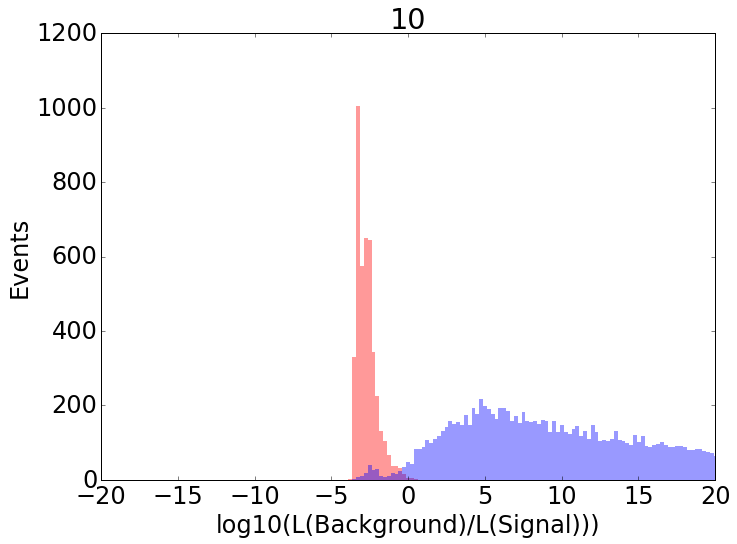

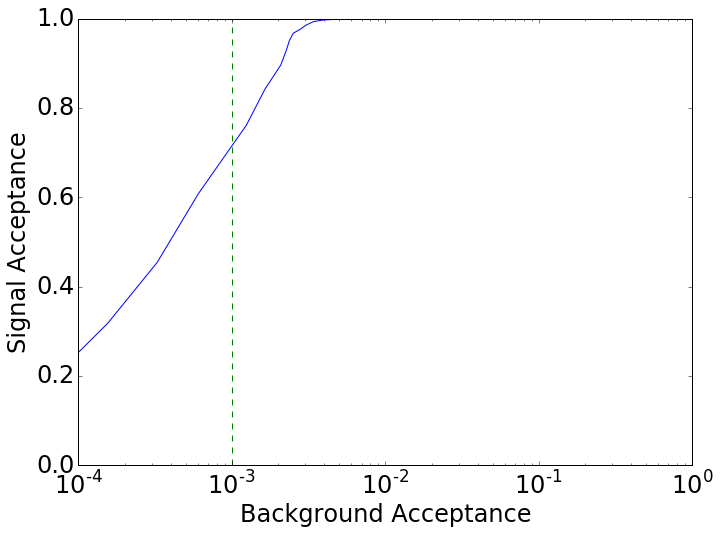

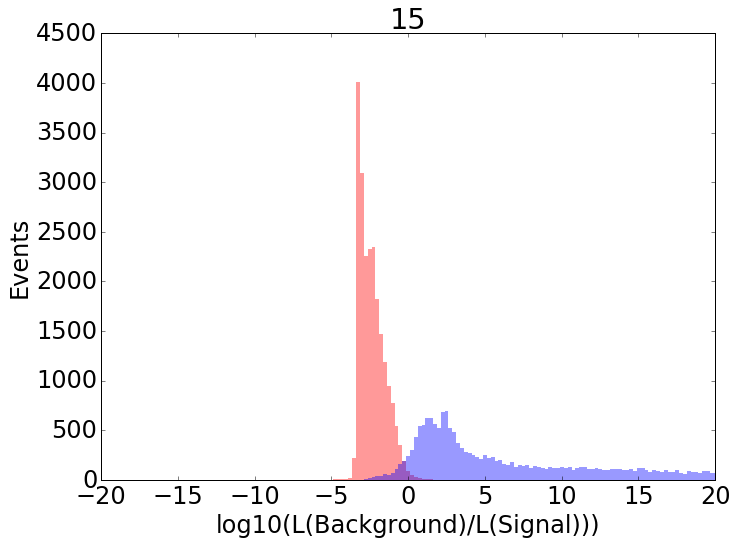

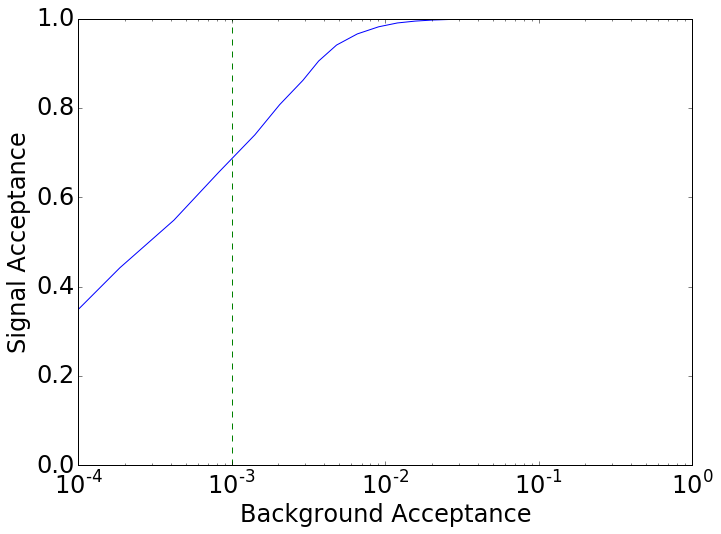

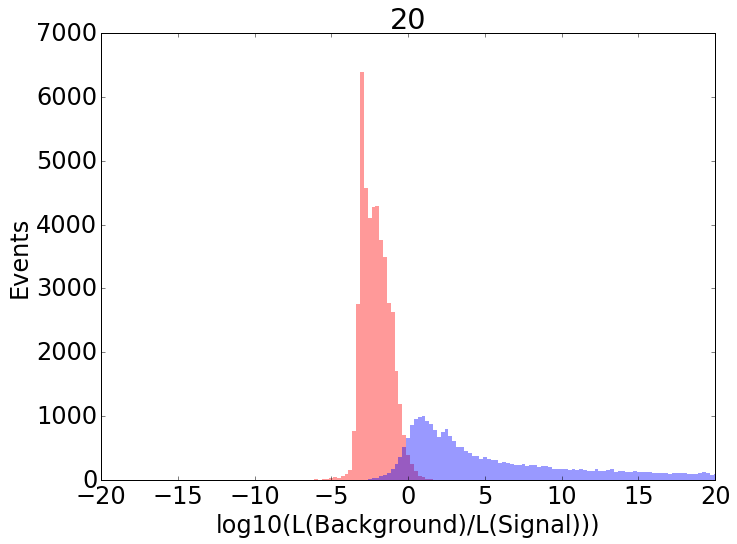

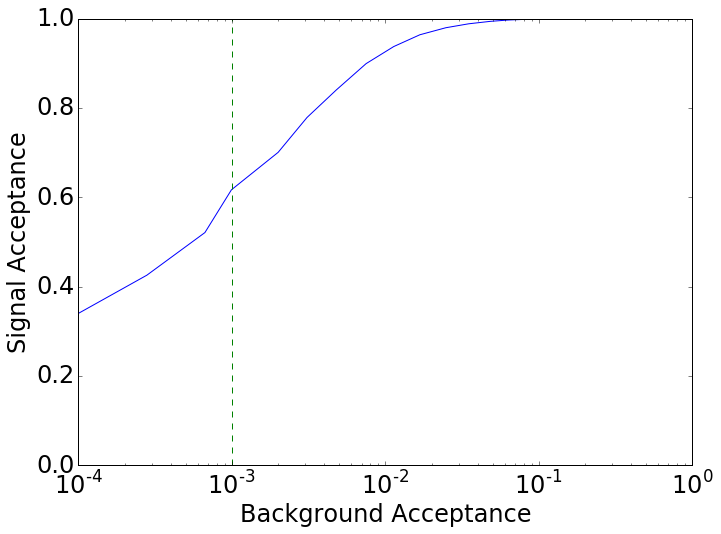

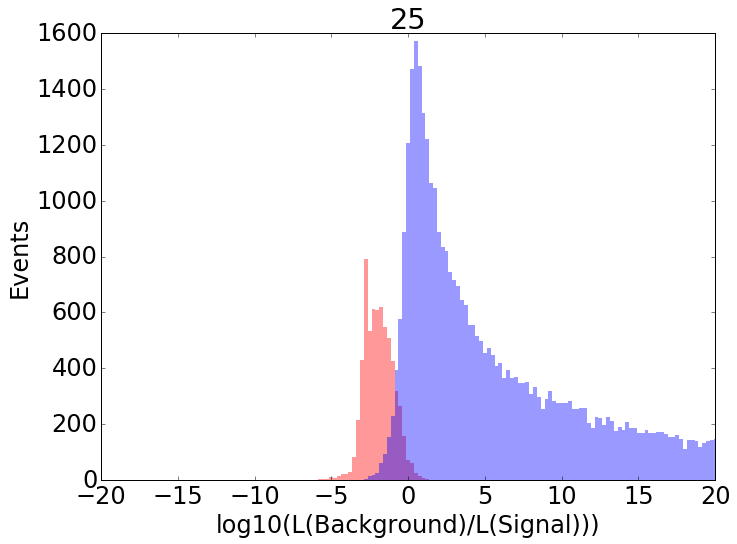

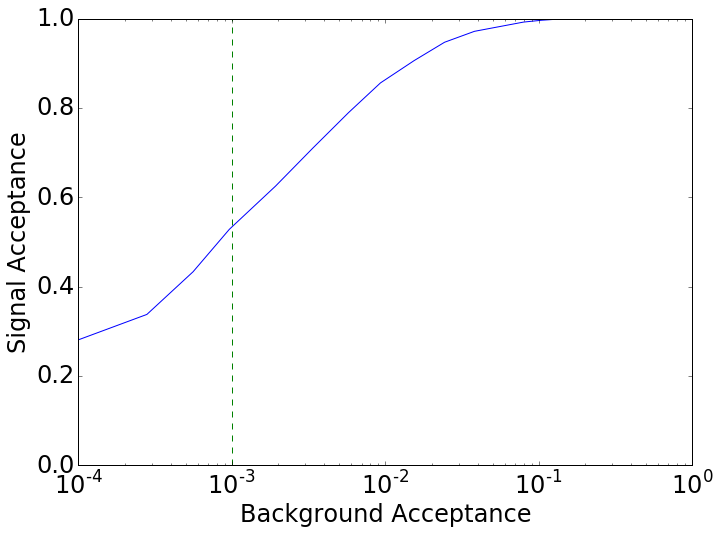

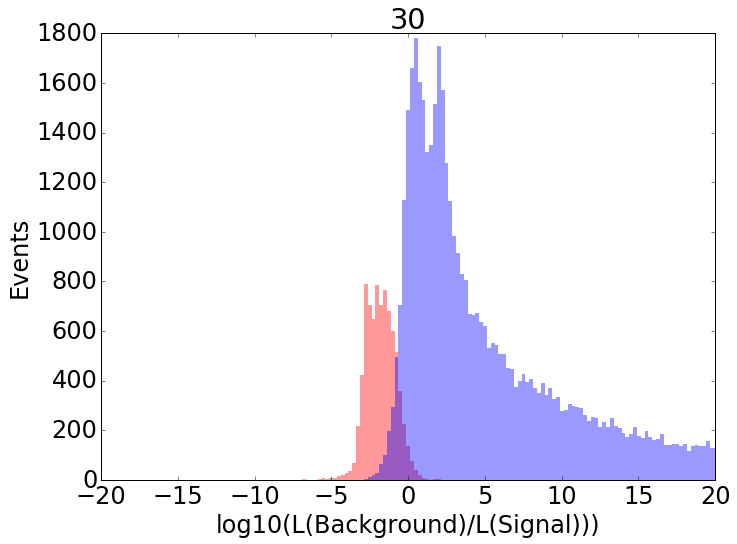

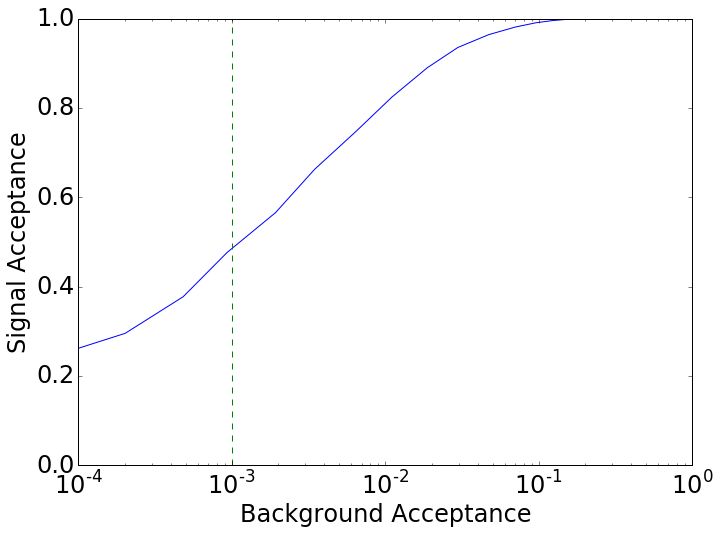

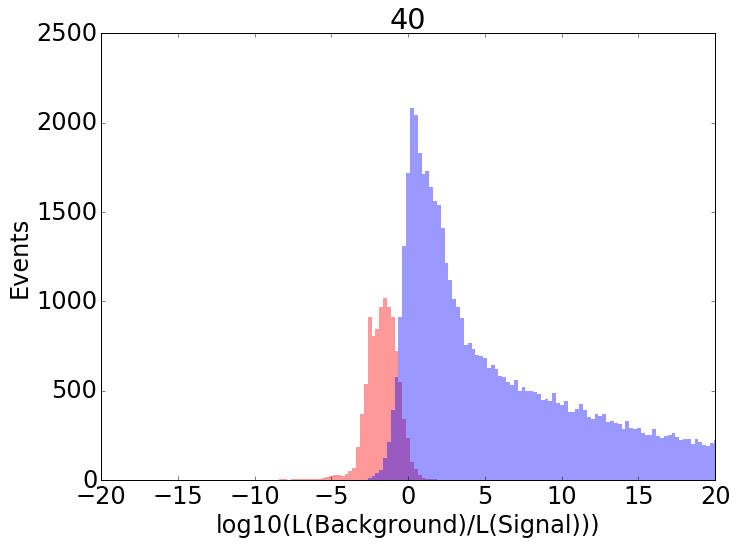

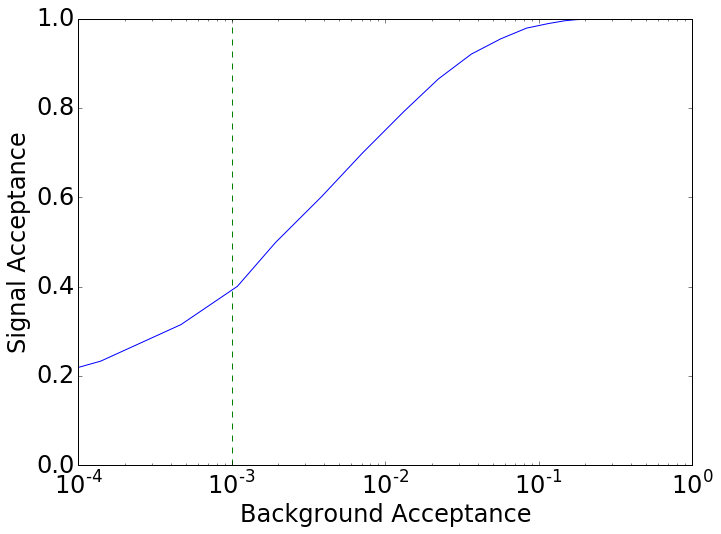

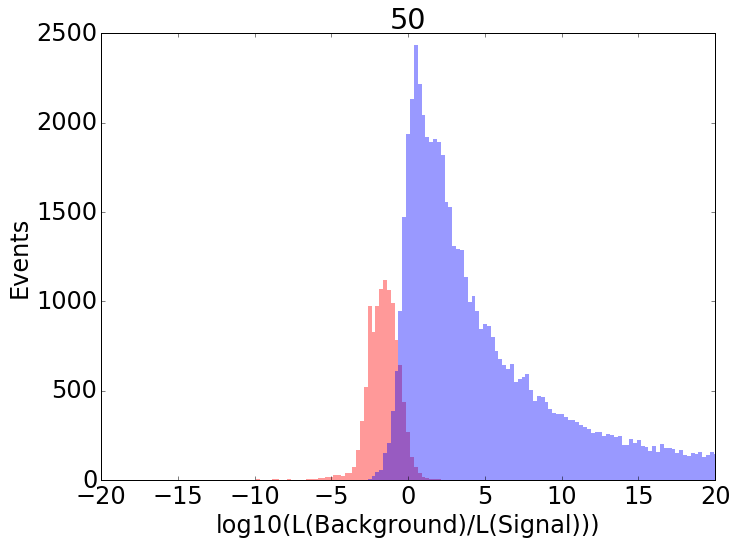

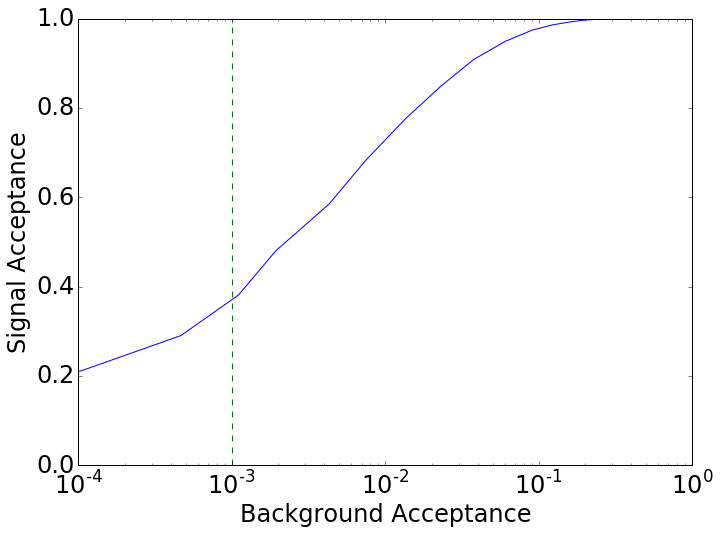

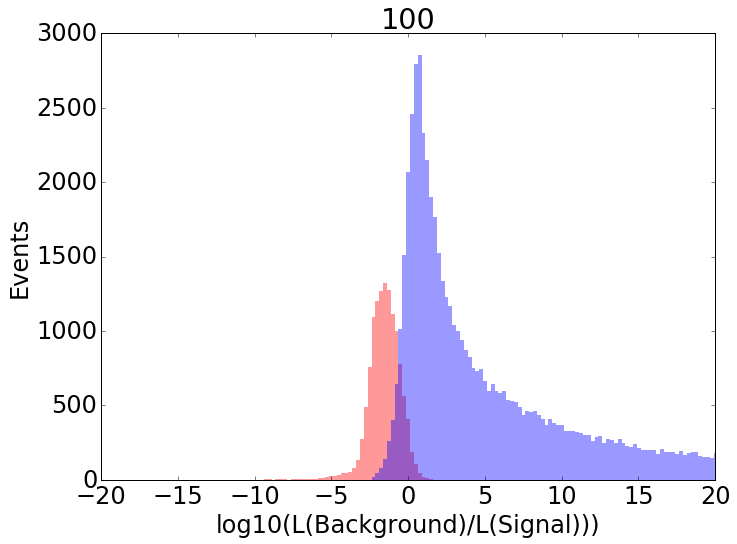

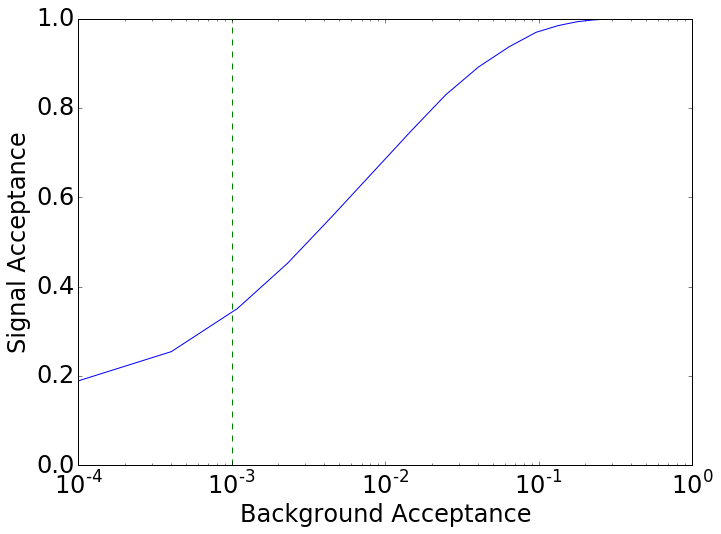

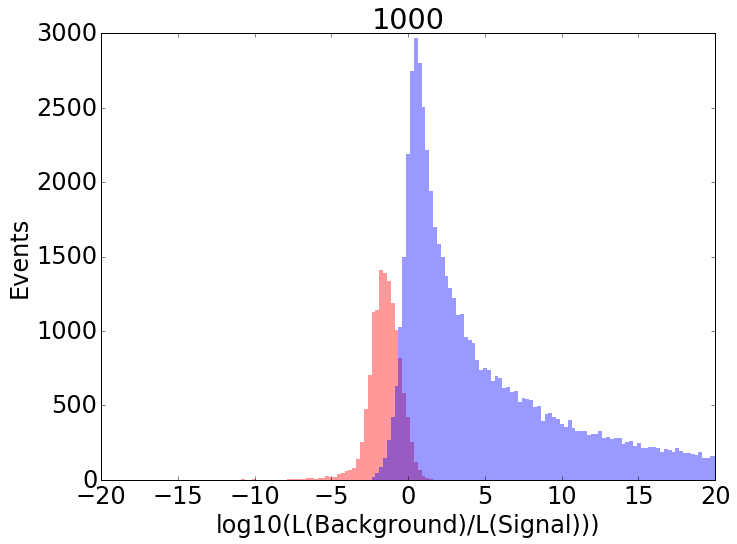

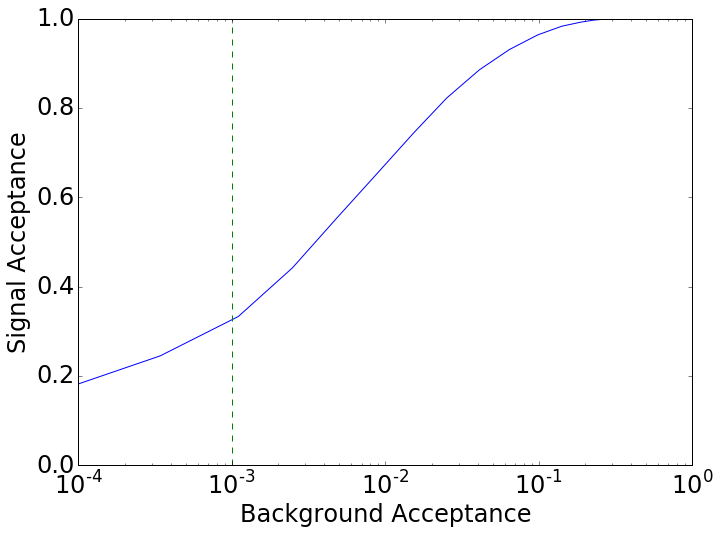

In [106]:
bgFrac=[]
sFrac=[]
for ii, mWmp in enumerate([10, 15, 20, 25, 30, 40,50,100,1000]):
    figure()
    nfmW= hist(listW[ii],\
           bins=linspace(-50,50,400),alpha=0.4,label='Signal',color='r',normed=0,linewidth=0)
    nfmBG= hist(listEr[ii],\
            bins=linspace(-50,50,400),alpha=0.4,label='Background',color='b',normed=0,linewidth=0)
    xlabel('log10(L(Background)/L(Signal)))')
    ylabel('Events')
    plt.title(str(mWmp))
    xlim([-20,20])
    bgFrac.append(cumsum(nfmBG[0])/size(listEr[ii])) #/sum(nfmBG[0]
    sFrac.append(cumsum(nfmW[0])/size(listW[ii]))
    
    figure()
    plot(bgFrac[ii],sFrac[ii])
    xlabel('Background Acceptance')
    ylabel('Signal Acceptance')
    xscale('log')
    xscale('log')
    xlim([1e-4,1])
    plt.plot([1e-3,1e-3],[0,1],'--')
    #accept_val=sFrac[ii][np.abs(bgFrac[ii]-1e-3).argmin()] #acceptance at 1/1000 rejection
    #plt.plot([0,1],[accept_val,accept_val],'--r')
    #plt.text(5e-4,accept_val*1.3,'{:1.1f}% Acceptance'.format(accept_val*100))
    

"\nfigure()\nfor ii, mWmp in enumerate([10, 20, 25, 30, 40,50,100,1000]):\n    frac=1/bgFrac[ii]\n    frac[isinf(frac)]=nan\n    plot(1/bgFrac[ii],sFrac[ii],label=str(mWmp)+' GeV',linewidth=3, color=colors[ii])\nxlabel('Background Rejection')\nylabel('Signal Acceptance')\nxscale('log')\nxticks([10,100, 1000,10000])\nax=gca()\n#ax.set_xticklabels( ['90%','99%', '99.9%','99.99%'] )\nax.set_xticklabels( ['1/10','1/10$^2$', '1/10$^3$','1/10$^4$'] )\nxlim([10,1e4])\nylim([0,1.05])\nlegend(loc='lower left', fontsize=20)\ngrid('on')\nplt.plot([1e-3,1e-3],[0,1],'--k',linewidth=2)\nplt.plot([1e-4,1],[0.5,0.5],'--k',linewidth=2)\n"

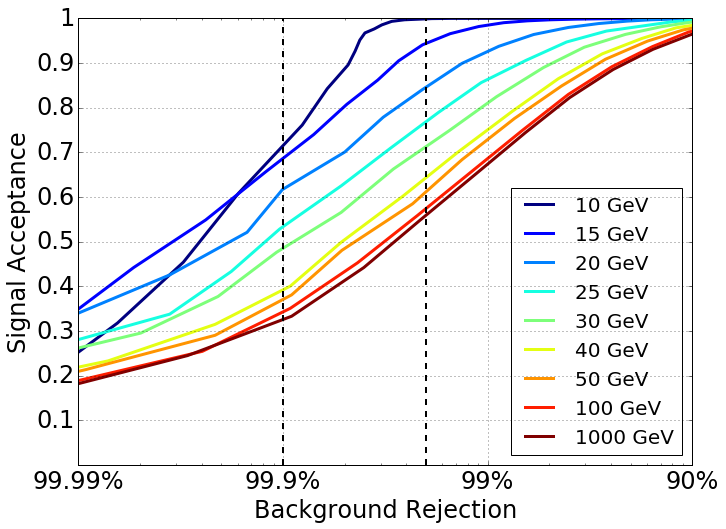

In [107]:
pylab.rcParams['figure.figsize'] = (11.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

start = 0.0
stop = 1.0
number_of_lines= 9
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.jet(x) for x in cm_subsection ]

for ii, mWmp in enumerate([10, 15, 20, 25, 30, 40,50,100,1000]):
    plot(bgFrac[ii],sFrac[ii],label=str(mWmp)+' GeV',linewidth=3, color=colors[ii])
xlabel('Background Rejection')
ylabel('Signal Acceptance')
xscale('log')
xlim([1e-4,0.1])
ylim([0.0,1.])
#xticks([10,100, 1000,10000])
yticks(np.arange(0,1.1,0.1))
ax=gca()
ax.set_xticklabels( ['99.999%','99.99%', '99.9%','99%','90%'] )
ax.set_yticklabels( ['',0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] )

legend(loc='lower right', fontsize=20)
grid('on')
plt.plot([1e-3,1e-3],[0,1],'--k',linewidth=2)
plt.plot([5e-3,5e-3],[0,1],'--k',linewidth=2)
#plt.plot([1e-4,1],[0.5,0.5],'--k',linewidth=2)


savefig('figs/ROC_ER-B8.png',dpi=200)
savefig('figs/ROC_ER-B8.pdf')

'''
figure()
for ii, mWmp in enumerate([10, 20, 25, 30, 40,50,100,1000]):
    frac=1/bgFrac[ii]
    frac[isinf(frac)]=nan
    plot(1/bgFrac[ii],sFrac[ii],label=str(mWmp)+' GeV',linewidth=3, color=colors[ii])
xlabel('Background Rejection')
ylabel('Signal Acceptance')
xscale('log')
xticks([10,100, 1000,10000])
ax=gca()
#ax.set_xticklabels( ['90%','99%', '99.9%','99.99%'] )
ax.set_xticklabels( ['1/10','1/10$^2$', '1/10$^3$','1/10$^4$'] )
xlim([10,1e4])
ylim([0,1.05])
legend(loc='lower left', fontsize=20)
grid('on')
plt.plot([1e-3,1e-3],[0,1],'--k',linewidth=2)
plt.plot([1e-4,1],[0.5,0.5],'--k',linewidth=2)
'''

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


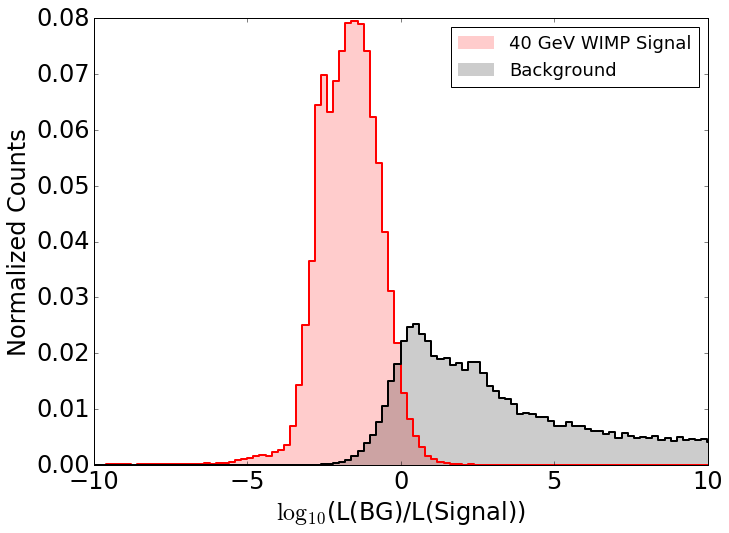

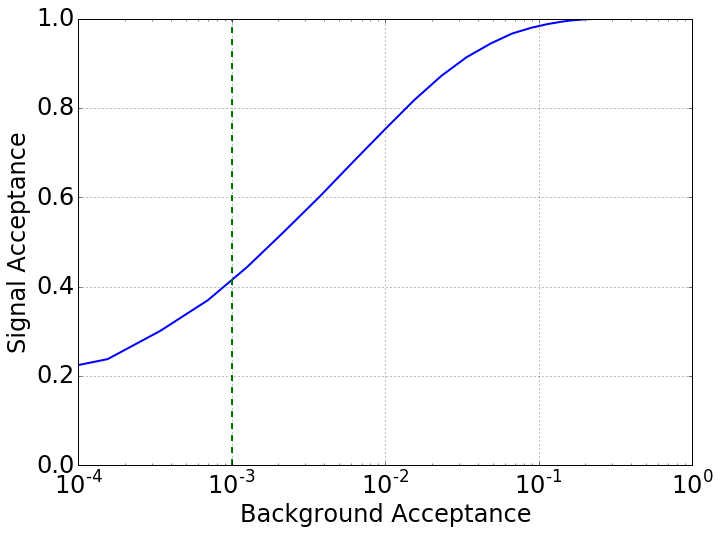

In [110]:
x_range_sel=[0, 50]
y_range_sel=[1.0,4.0]
pdf_er, x_er, y_er, xx, yy= pdf_gen(S1_cut_er, log10(S2_cut_er/S1_cut_er),x_range_sel,y_range_sel)
pdf_wm, x_w, y_w, xx, yy = pdf_gen(S1_cut_mw40,log10(S2_cut_mw40/S1_cut_mw40),x_range_sel,y_range_sel)

FM=np.log10(pdf_er)-np.log10(pdf_wm)
FM[FM>200]=200
FM[isinf(FM)]=200
FM[isnan(FM)]=200
Z=interp2d(xx,yy,FM,kind='linear')

width=0.2
xbins=np.arange(-20,40,width)

nfmW, edgesW = histogram(interpAD(Z,x_w,y_w),bins=xbins, normed=0)
nfmBG, edgesBG= histogram(interpAD(Z,x_er,y_er),bins=xbins, normed=0)
nfmW=nfmW/size(x_w)
nfmBG=nfmBG/size(x_er)

plt.bar(edgesW[:-1], nfmW ,alpha=0.2,label='40 GeV WIMP Signal',color='r',linewidth=0, width=width)
plt.step(edgesW[1:],nfmW,color='r',linewidth=2)
plt.bar(edgesBG[:-1], nfmBG ,alpha=0.2,label='Background',color='k',linewidth=0, width=width)
plt.step(edgesBG[1:],nfmBG,color='k',linewidth=2)

xlim([-10,10])
legend(fontsize=18)
xlabel('$\mathrm{log_{10}}$(L(BG)/L(Signal))')
ylabel('Normalized Counts')

savefig('figs/MV_Disc_40-8B.png',dpi=200)
savefig('figs/MV_Disc_40-8B.pdf')

figure()
bgFrac=cumsum(nfmBG)
sFrac=cumsum(nfmW)

plot(bgFrac,sFrac,linewidth=2)
xlabel('Background Acceptance')
ylabel('Signal Acceptance')
xscale('log')
xscale('log')
xlim([1e-4,1])
grid('on')

plt.plot([1e-3,1e-3],[0,1],'--',linewidth=2)
#plt.plot([5e-3,5e-3],[0,1],'--')
accept_val=sFrac[np.abs(bgFrac-1e-3).argmin()] #acceptance at 1/1000 rejection
#plt.plot([0,1],[accept_val,accept_val],'--r')
#plt.text(5e-4,accept_val*1.3,'{:1.1f}% Acceptance'.format(accept_val*100))

savefig('figs/ROC_40.png',dpi=200)
savefig('figs/ROC_40.pdf')

<h1> Sweep WIMP masses and make a movie </h1>

total rate above 0.00 keV = 1.05686e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 1.68964e-09
total rate above 0.00 keV = 1.02044e+06 [evts/kg/day per pb]
Detector exposure factor per pb = 1.74995e-09
total rate above 0.00 keV = 981297 [evts/kg/day per pb]
Detector exposure factor per pb = 1.81975e-09
total rate above 0.00 keV = 941743 [evts/kg/day per pb]
Detector exposure factor per pb = 1.89618e-09
total rate above 0.00 keV = 902935 [evts/kg/day per pb]
Detector exposure factor per pb = 1.97768e-09
total rate above 0.00 keV = 865375 [evts/kg/day per pb]
Detector exposure factor per pb = 2.06351e-09
total rate above 0.00 keV = 829555 [evts/kg/day per pb]
Detector exposure factor per pb = 2.15262e-09
total rate above 0.00 keV = 795668 [evts/kg/day per pb]
Detector exposure factor per pb = 2.24429e-09
total rate above 0.00 keV = 763616 [evts/kg/day per pb]
Detector exposure factor per pb = 2.3385e-09
total rate above 0.00 keV = 733698 [evts/kg/day per pb]
Detector exposure

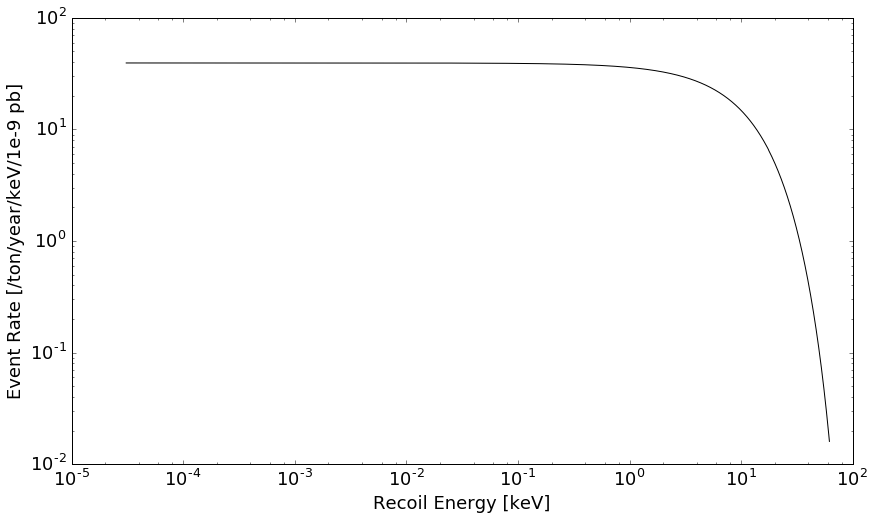

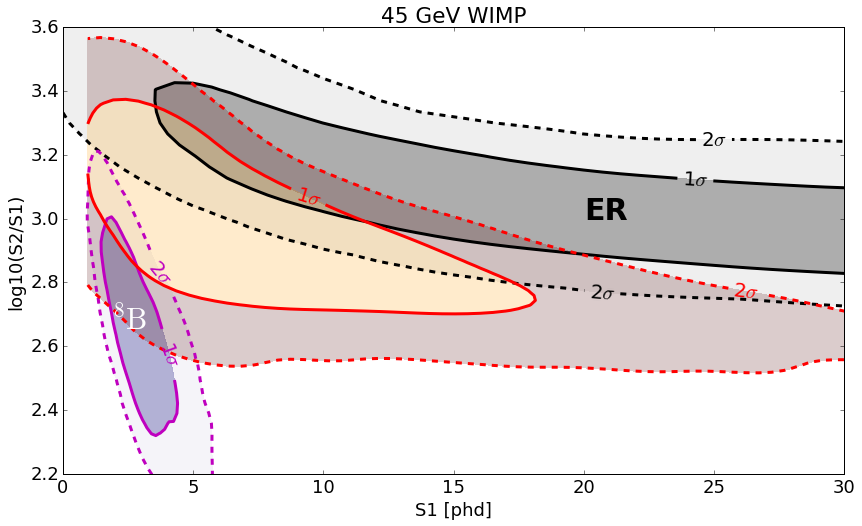

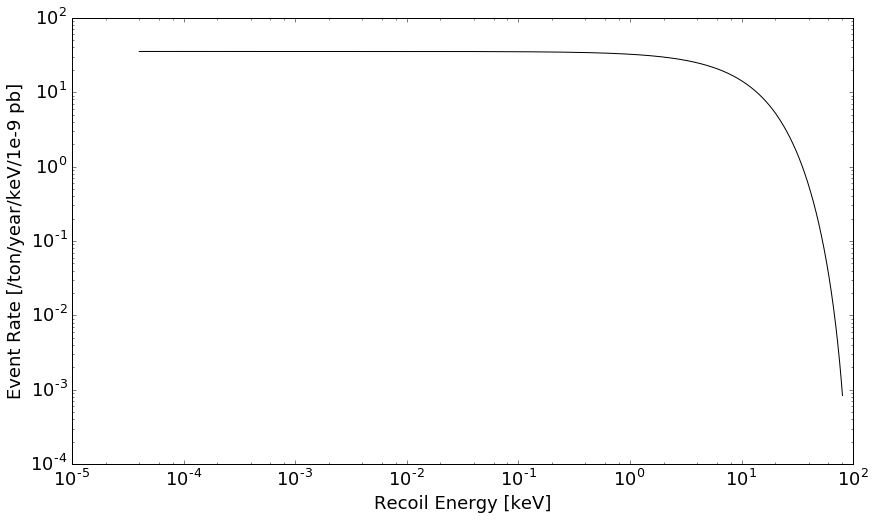

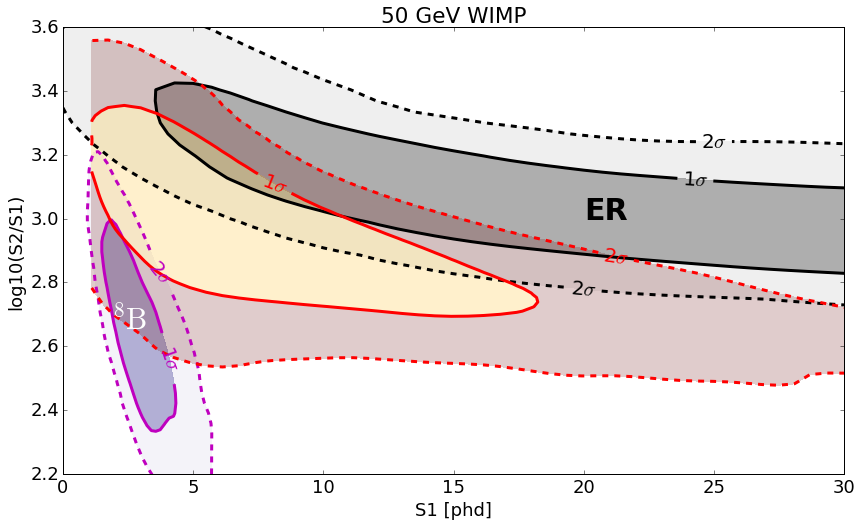

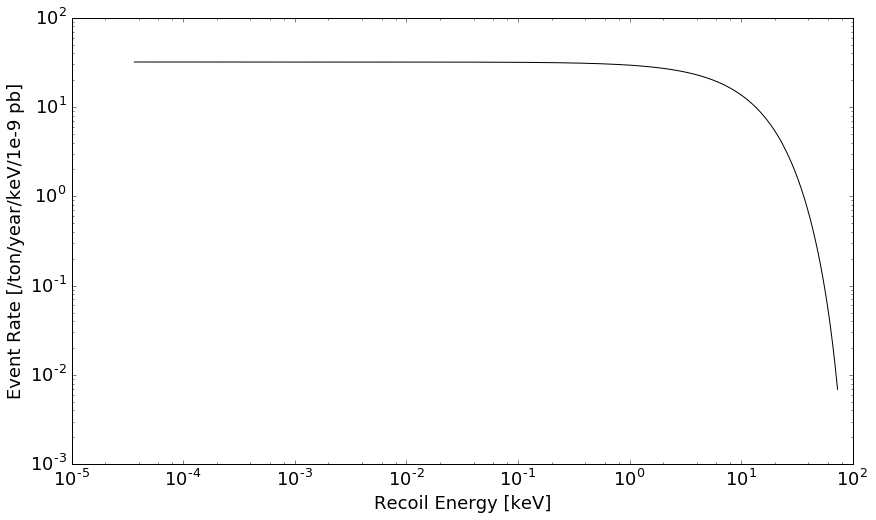

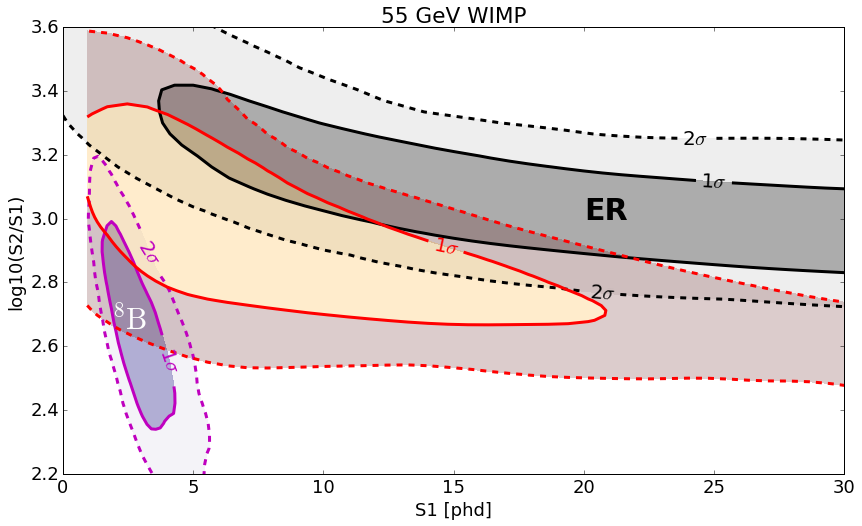

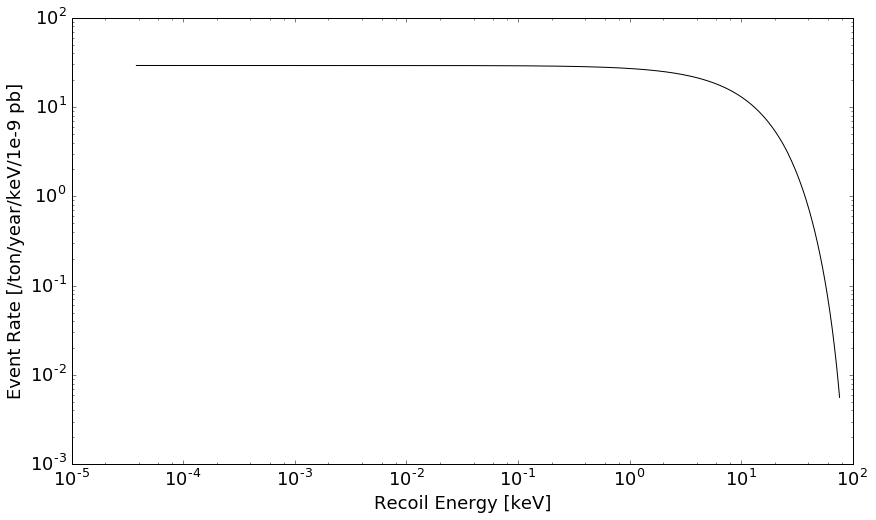

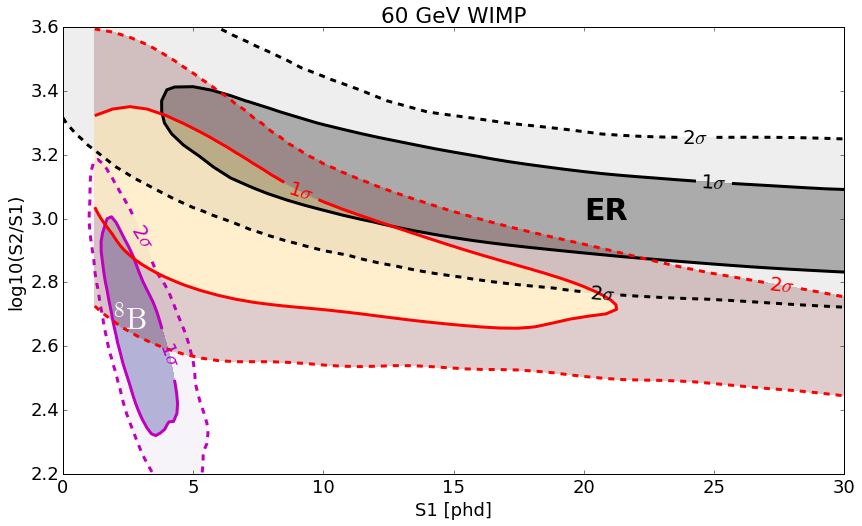

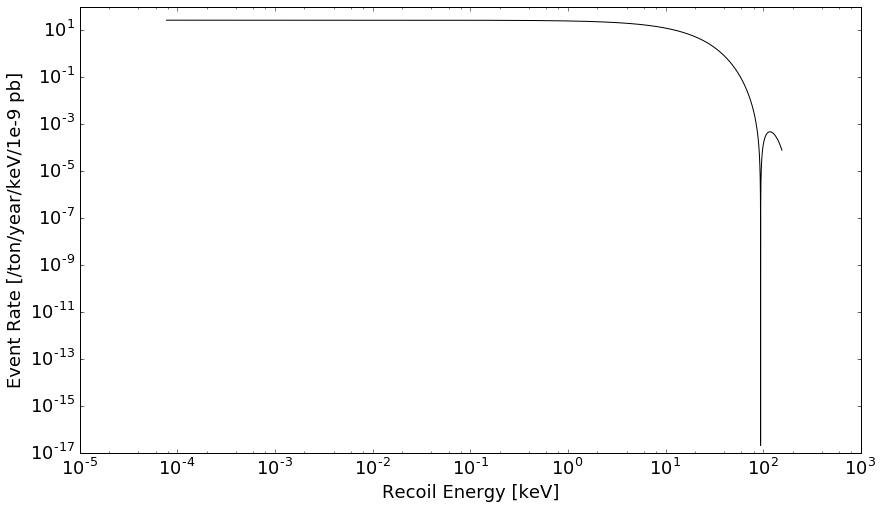

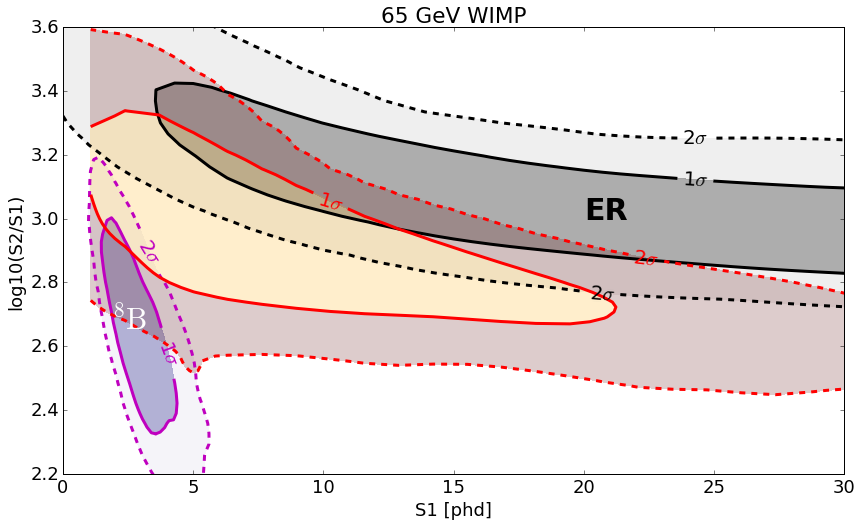

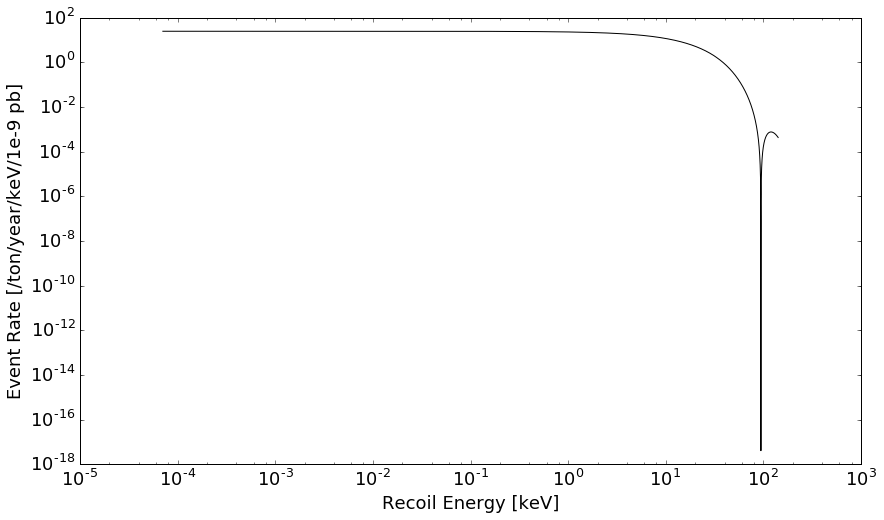

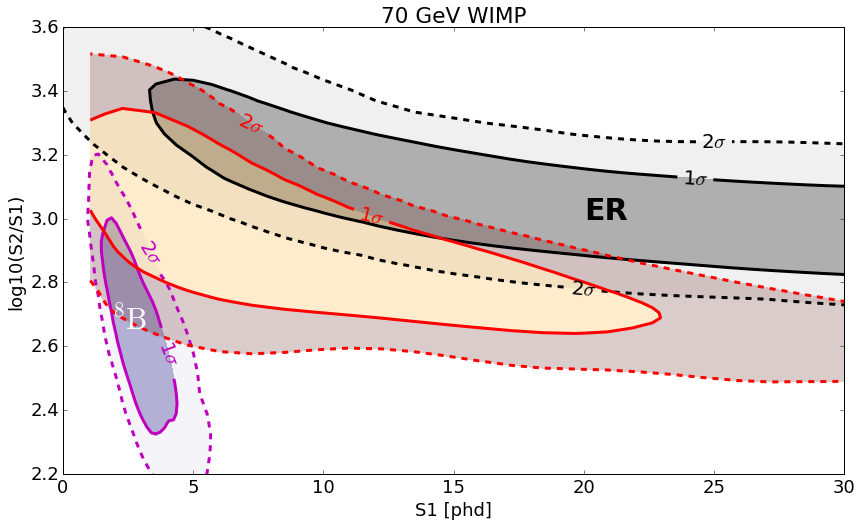

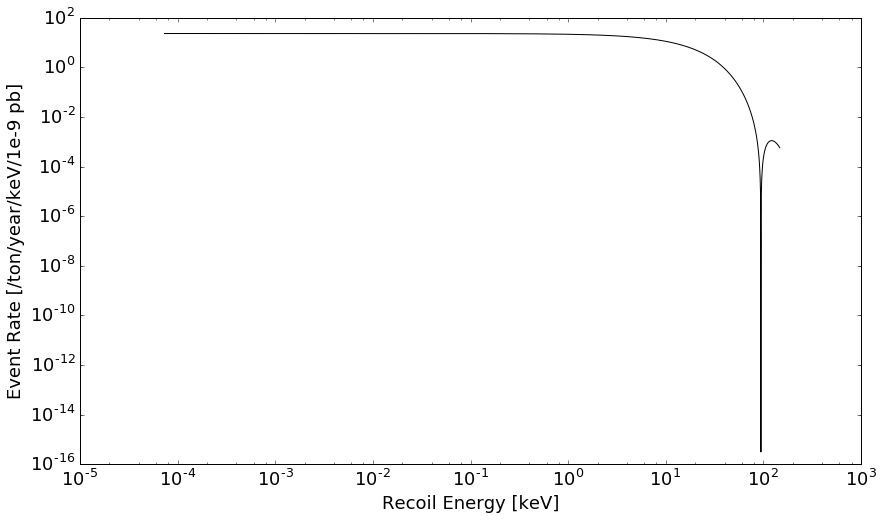

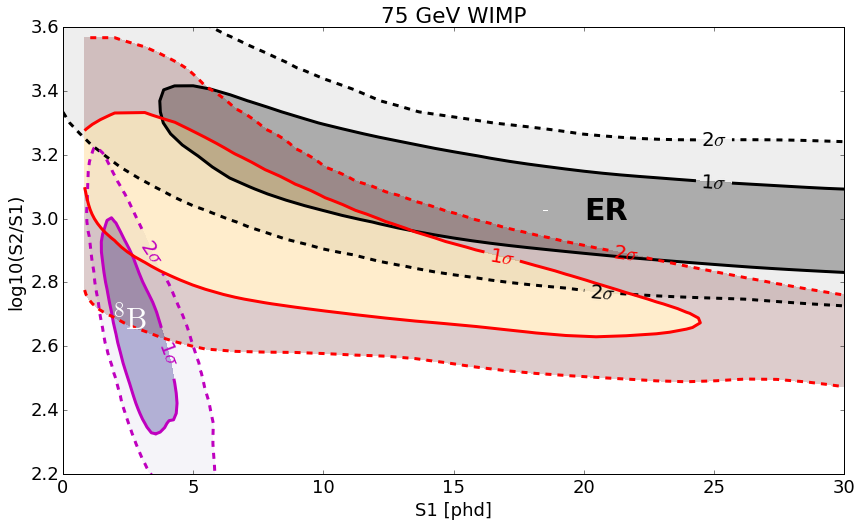

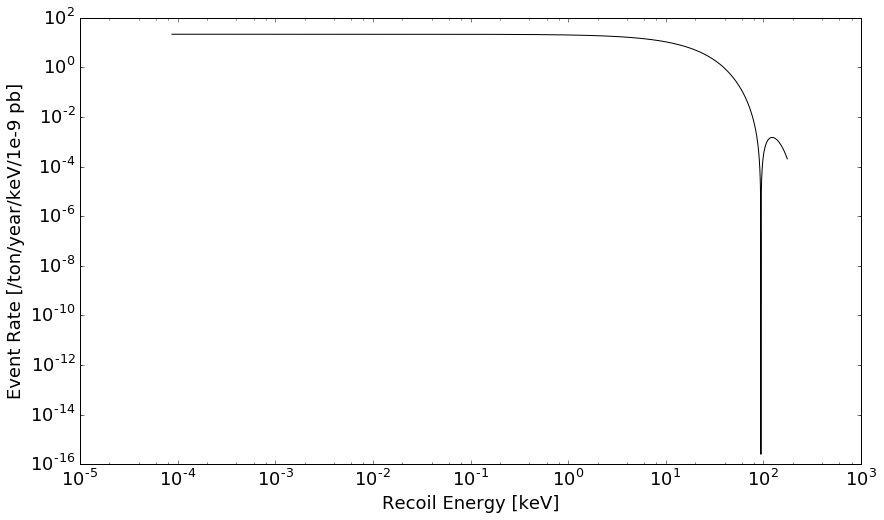

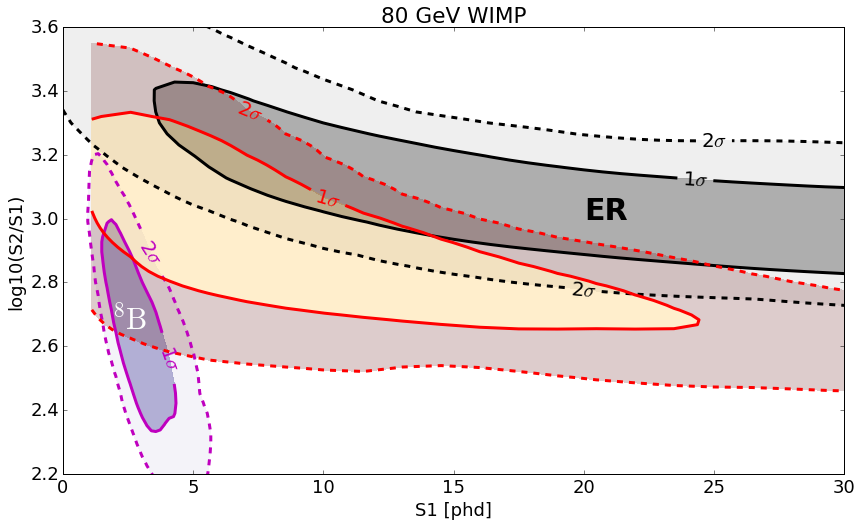

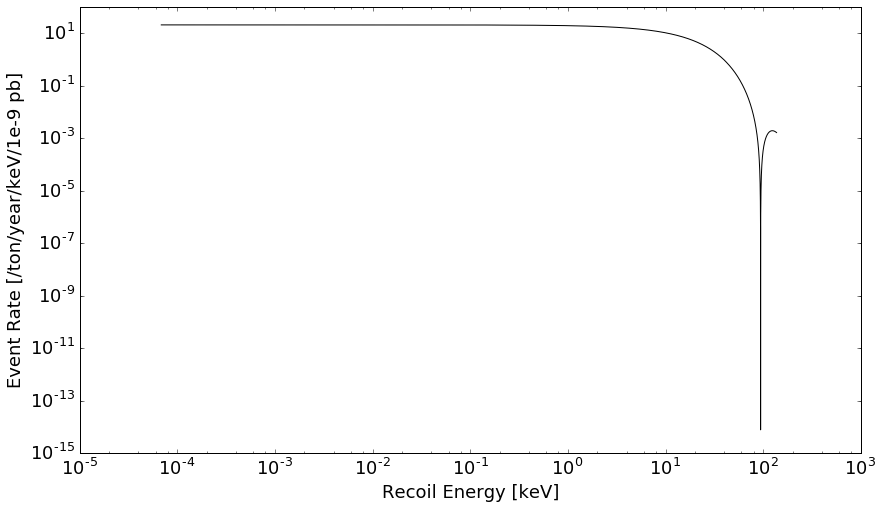

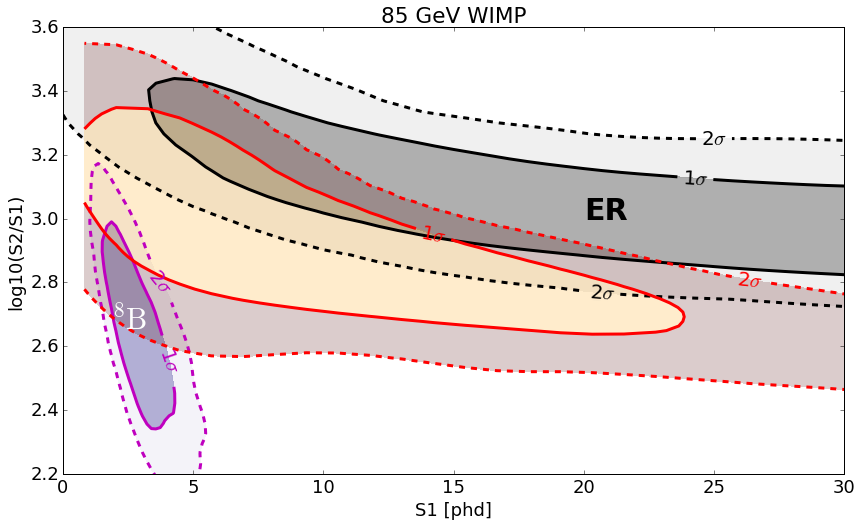

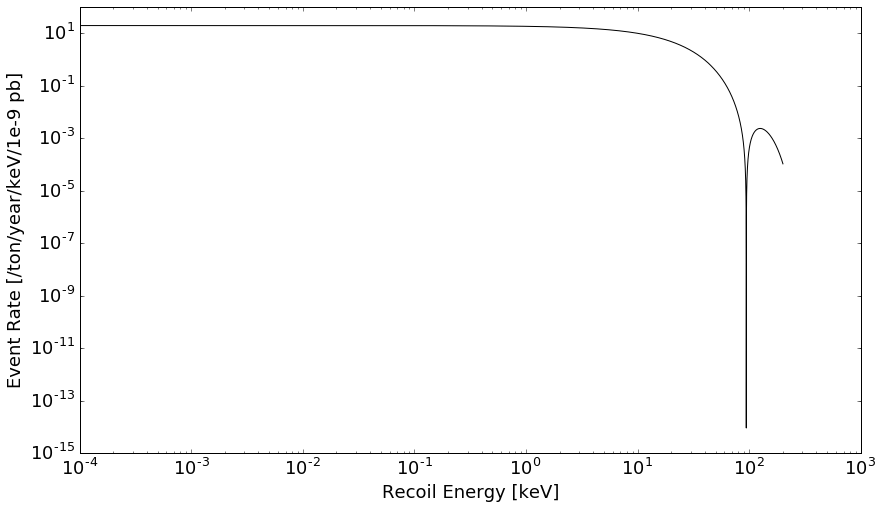

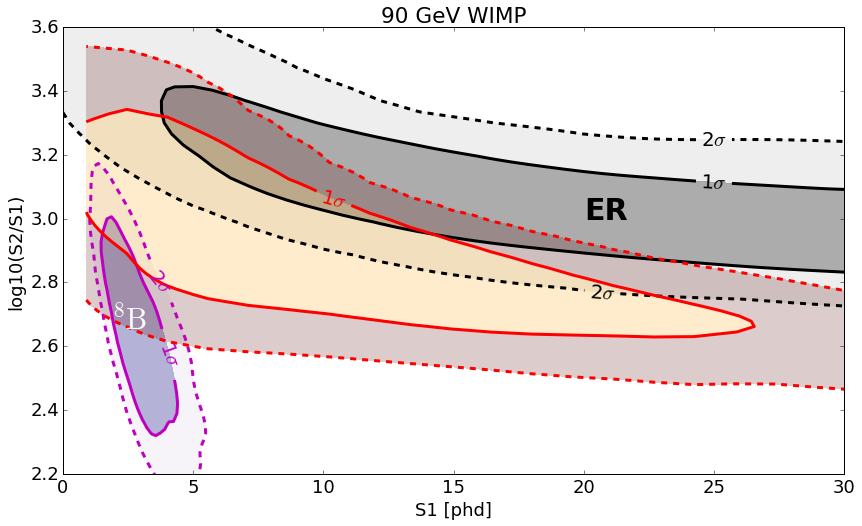

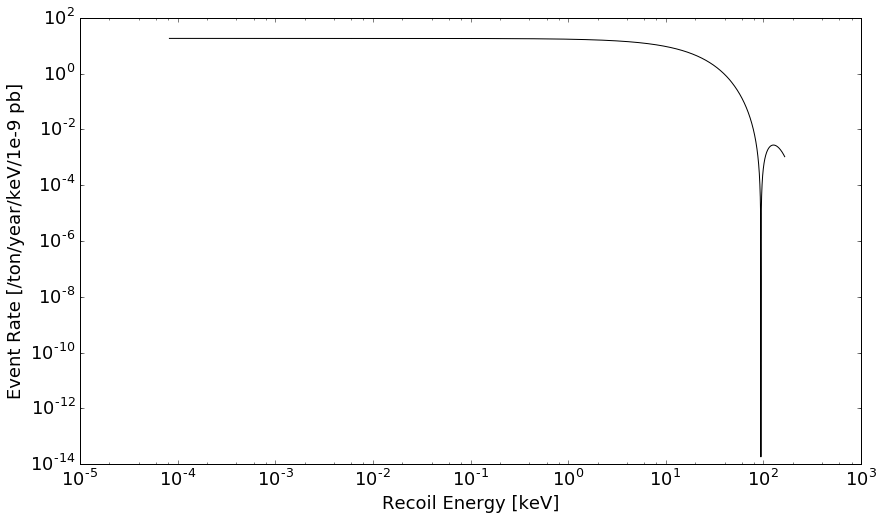

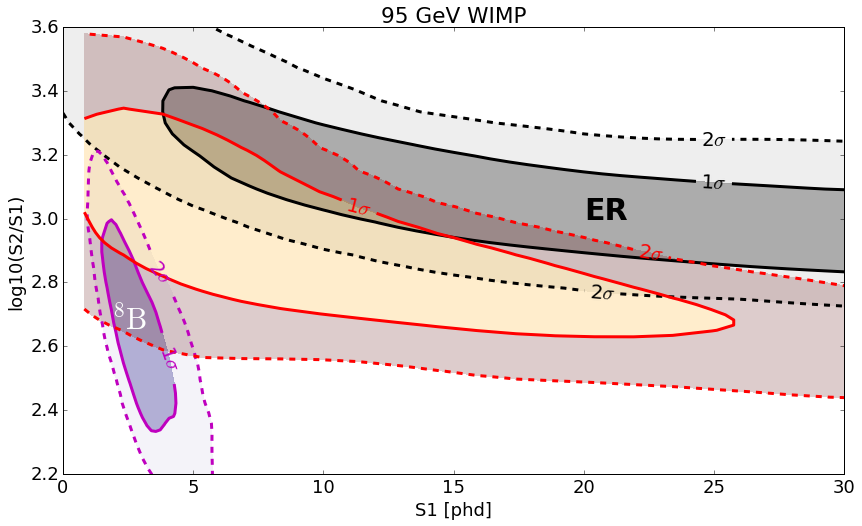

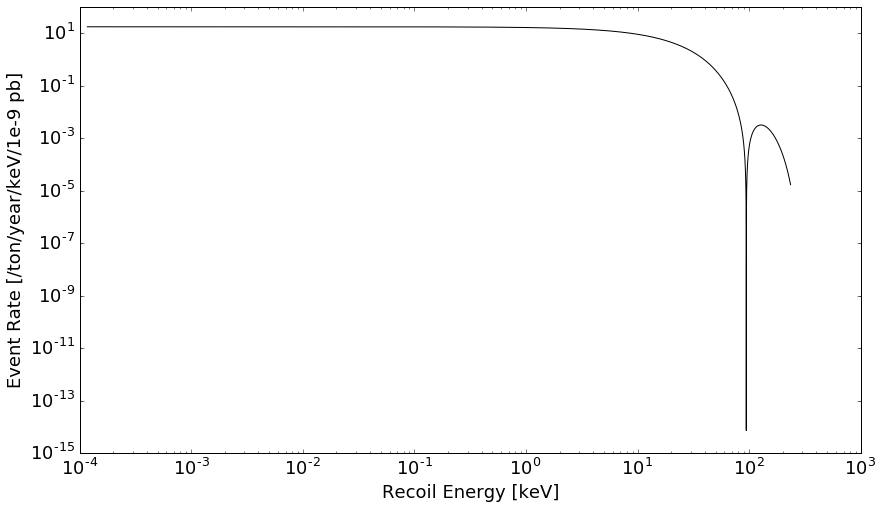

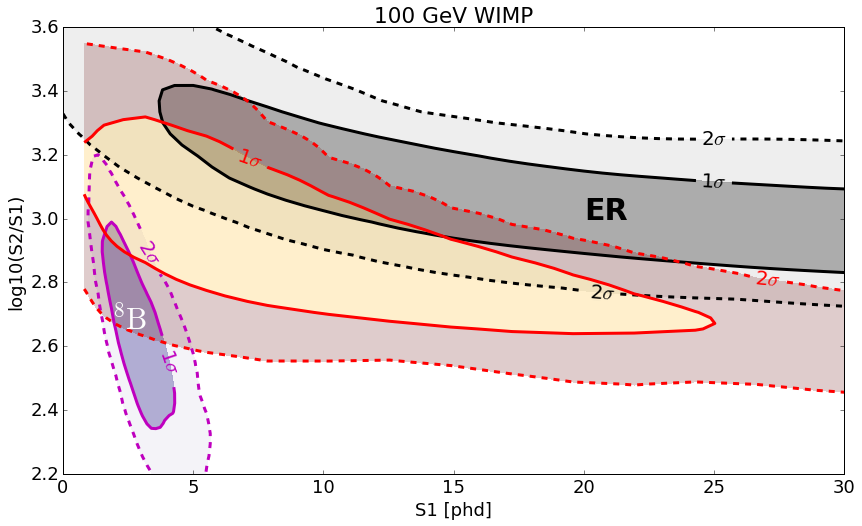

In [264]:
NEST.SetParticleType(0) #0=NR
#Generate WIMPs
for ii, mWmp in enumerate(int32(np.arange(45,105,5))):
    if mWmp<10:
        nSim=2e6
        bins=50
    elif mWmp<25:
        nSim=1e5
        bins=50
    else:
        nSim=2e4
        bins=100
        
    Er, Nph, Ne, S1, S2, S1c, S2c, WmpRate, Det_exposure_factor=WIMP2NphNe(NEST=NEST,mWmp=mWmp,nSim=nSim)
    # 1e-45 cm^2 cross section
    title='MOV_'+str(ii)+'_WIMP_M'+str(mWmp)
    
    WS_cut=(S1c>0) & (S2>=S2raw_min)
    S1_cut=S1c[WS_cut]
    S2_cut=S2c[WS_cut]
    
    S1_cut_mw=S1_cut
    S2_cut_mw=S2_cut
    
    figure()
    plt.xlabel('S1 [phd]')
    plt.ylabel('log10(S2/S1)')
    xlim([0,30])
    pdfcont(S1_cut_er,log10(S2_cut_er/S1_cut_er),nsig=2,color='k',fill=True,fill_alpha=0.5, colormap=plt.cm.Greys,xlim=[0,35])
    pdfcont(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8),nsig=2,color='m',fill=True,fill_alpha=0.6, colormap=plt.cm.Purples)
    pdfcont(S1_cut_mw,log10(S2_cut_mw/S1_cut_mw),nsig=2,color='r',fill=True,fill_alpha=0.2, colormap=plt.cm.hot,bins=bins)
    
    plt.text(1.9,2.65,r'$\bf \mathrm{^8B}$',fontsize=30,color='w',fontweight='bold')
    plt.text(20,3.0,'ER',fontsize=30,color='k',fontweight='bold')
    #plt.text(13,3.65,str(mWmp)+' GeV WIMP',\
    #         fontsize=24,color='r',fontweight='bold')
    plt.title(str(mWmp)+' GeV WIMP')
    
    plt.xlim([0,30])
    plt.ylim([2.2,3.6])
    savefig('figs/'+title+'.png',dpi=200)

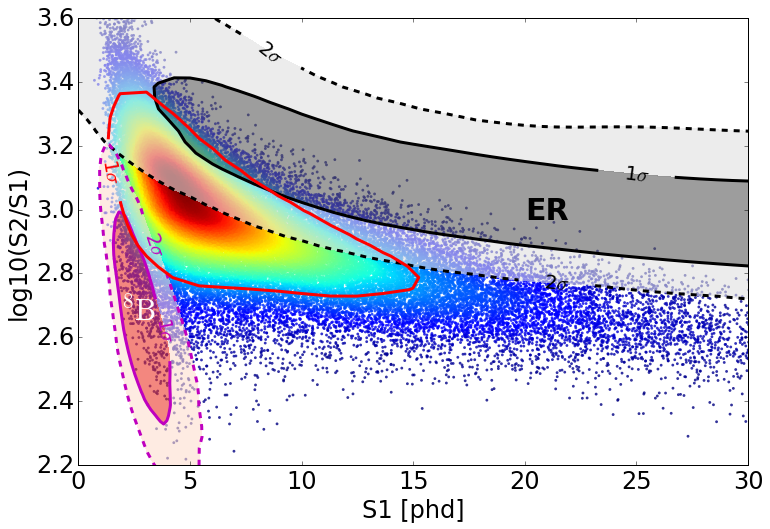

In [145]:
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

title='40GeV_cont'

plt.figure()
scatterColor(S1_cut_mw40,log10(S2_cut_mw40/S1_cut_mw40))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)
#pdfcont(S1_cut_er,log10(S2_cut_er/S1_cut_er),color='k',nsig=2)
#pdfcont(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8),color='m',nsig=1)
#pdfcont(S1_cut_wm50,log10(S2_cut_wm50/S1_cut_wm50),color='r',nsig=2)

pdfcont(S1_cut_er,log10(S2_cut_er/S1_cut_er),nsig=2,color='k',fill=True,fill_alpha=0.6,\
        colormap=plt.cm.Greys,xlim=[0,35])
pdfcont(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8),nsig=2,color='m',fill=True,fill_alpha=0.6, colormap=plt.cm.Reds)
pdfcont(S1_cut_mw40,log10(S2_cut_mw40/S1_cut_mw40),nsig=1,color='r',fill=False)

plt.text(1.9,2.65,r'$\mathrm{^8B}$',fontsize=30,color='w',fontweight='bold')
plt.text(20,2.97,'ER',fontsize=30,color='k',fontweight='bold')

plt.xlim([0,30])
plt.ylim([2.2,3.6])
savefig('figs/'+title+'_S2S1.png',dpi=200)
savefig('figs/'+title+'_S2S1.pdf')

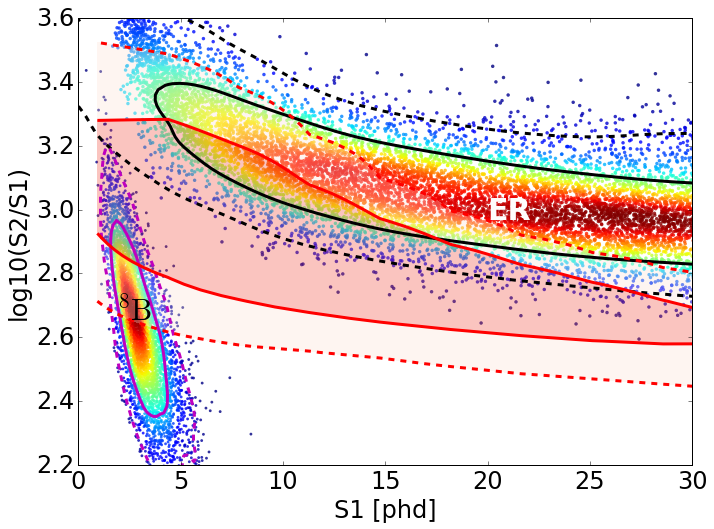

In [128]:
title='1000GeV_cont'

er_max=int(size(S2_cut_er)/2) # /er_exp ... 1 LZ exposure

plt.figure()
#scatterColor(S1_cut_mw40,log10(S2_cut_mw40/S1_cut_mw40))
scatterColor(S1_cut_er[0:er_max],log10(S2_cut_er[0:er_max]/S1_cut_er[0:er_max]),size=12)
#plt.scatter(S1_cut_er[0:er_max],log10(S2_cut_er[0:er_max]/S1_cut_er[0:er_max]),color='k',alpha=0.5,s=10)
scatterColor(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)

#plot ER band, with a smooth spline #########################################
#s = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e, s=.01)
#s_ub = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e+1*std_S2oS1_e, s=.01) #1 sigma 
#s_lb = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e-1*std_S2oS1_e, s=.01)
#plot(S1_bin_cen_e,s_ub(S1_bin_cen_e),'-k',linewidth=3)
#plot(S1_bin_cen_e,s_lb(S1_bin_cen_e),'-k',linewidth=3)
#s_ub = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e+2*std_S2oS1_e, s=.01) #2 sigma
#s_lb = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e-2*std_S2oS1_e, s=.01)
#plot(S1_bin_cen_e,s(S1_bin_cen_e),'-k',linewidth=3)
#plot(S1_bin_cen_e,s_ub(S1_bin_cen_e),'--k',linewidth=3)
#plot(S1_bin_cen_e,s_lb(S1_bin_cen_e),'--k',linewidth=3)
##################################################################################

pdfcont(S1_cut_er[0:er_max],log10(S2_cut_er[0:er_max]/S1_cut_er[0:er_max]),nsig=2,color='k',fill=False,fill_alpha=0.6,\
        colormap=plt.cm.Greys,xlim=[0,35],label=False,bins=100)
pdfcont(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8),nsig=2,color='m',fill=False,fill_alpha=0.6,\
        colormap=plt.cm.Reds,label=False)
pdfcont(S1_cut_mw1000,log10(S2_cut_mw1000/S1_cut_mw1000),nsig=2,color='r',fill=True, fill_alpha=0.3, label=False,bins=100)#

plt.text(1.9,2.65,r'$\mathrm{^8B}$',fontsize=30,color='k',fontweight='bold')
plt.text(20,2.97,'ER',fontsize=30,color='w',fontweight='bold')
#plt.text(16,3.3,'ER',fontsize=30,color='k',fontweight='bold')

plt.xlim([0,30])
plt.ylim([2.2,3.6])
savefig('figs/'+title+'_S2S1-H.png',dpi=200)
savefig('figs/'+title+'_S2S1-H.pdf')

<h1> Plot 1 LZ exposure </h1>

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:68: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:69: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:71: RuntimeWarning: invalid value encountered in less_equal


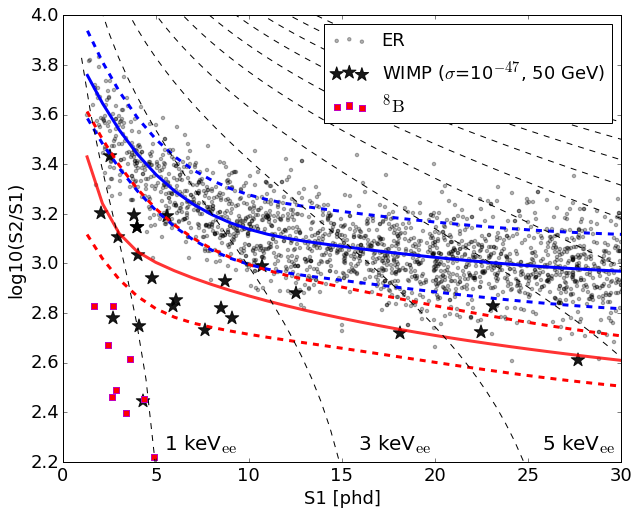

In [97]:
#search below 50% NR mean and from 3 to 20 PE (1.5 to 6.5 keVee with g1=0.075)
S1_min=1
S1_max=50
S2raw_min=450 #about 5 electrons
title='mW50-sig-1e47-'

#define combined cnns signal
S1_cnns=np.hstack([S1_b8,S1_atm,S1_hep,S1_dsn])
S2_cnns=np.hstack([S2_b8,S2_atm,S2_hep,S2_dsn])
S2_cnns_raw=np.hstack([S2_b8_raw,S2_atm_raw,S2_hep_raw,S2_dsn_raw])
S1_er=np.hstack([S1_pp,S1_Rn,S1_Rn220])
S2_er=np.hstack([S2_pp,S2_Rn,S2_Rn220])
S2_er_raw=np.hstack([S2_pp_raw,S2_Rn_raw,S2_Rn220_raw])

#make cuts to plot Rn, PP, cnns and 50 GeV WIMP signal
WS_cut_rn=(inrange(S1_Rn,[S1_min,S1_max])) & (S2_Rn_raw>=S2raw_min)
WS_cut_pp=(inrange(S1_pp,[S1_min,S1_max])) & (S2_pp_raw>=S2raw_min)
WS_cut_cnns=(inrange(S1_cnns,[S1_min,S1_max])) & (S2_cnns_raw>=S2raw_min)
WS_cut_er=(inrange(S1_er,[S1_min,S1_max])) & (S2_er_raw>=S2raw_min)
WS_cut_wmp=(inrange(S1_mw50,[S1_min,S1_max])) & (S2_mw50_raw>=S2raw_min)


#plot NR band
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=3,alpha=0.8)
s = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n, s=.01)
s_ub = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n+1.28*std_S2oS1_n, s=.01) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n-1.28*std_S2oS1_n, s=.01)
plot(S1_bin_cen_n,s_ub(S1_bin_cen_n),'--r',linewidth=3)
plot(S1_bin_cen_n,s_lb(S1_bin_cen_n),'--r',linewidth=3)

#plot ER band, with a smooth spline
s = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e, s=.01)
s_ub = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e+1.28*std_S2oS1_e, s=.01) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e-1.28*std_S2oS1_e, s=.01)
plot(S1_bin_cen_e,s(S1_bin_cen_e),'-b',linewidth=3)
plot(S1_bin_cen_e,s_ub(S1_bin_cen_e),'--b',linewidth=3)
plot(S1_bin_cen_e,s_lb(S1_bin_cen_e),'--b',linewidth=3)

plt.scatter(S1_er[WS_cut_er],log10(S2_er[WS_cut_er]/S1_er[WS_cut_er]),color='k',s=12,alpha=0.3,label='ER')
#plt.scatter(S1_Rn[WS_cut_rn],log10(S2_Rn[WS_cut_rn]/S1_Rn[WS_cut_rn]),color='magenta',s=10,alpha=0.3,label='ER')
#plt.scatter(S1_pp[WS_cut_pp],log10(S2_pp[WS_cut_pp]/S1_pp[WS_cut_pp]),color='blue',s=15,alpha=0.3,label='PP Solar',marker='^',edgecolor='b',linewidths=1)


plt.scatter(S1_mw50[WS_cut_wmp],log10(S2_mw50[WS_cut_wmp]/S1_mw50[WS_cut_wmp]),s=200\
            ,color="k", alpha=0.9, edgecolor='k', marker='*',label=r'WIMP ($\rm{\sigma}$=10$\rm{^{-47}}$, 50 GeV)')

plt.scatter(S1_cnns[WS_cut_cnns],log10(S2_cnns[WS_cut_cnns]/S1_cnns[WS_cut_cnns]),\
            color='red',s=40,alpha=1,marker='s',label=r'$\rm{^8B}$',edgecolor='m')
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)

#plot NR mean, with a smooth spline, and calculate number of WS candidates
#sNR = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n)
#WS_under_NRmean= sum((log10(S2[WS_cut]/S1[WS_cut])<=sNR(S1[WS_cut])) ) 
#WS_above_NRmean= sum((log10(S2[WS_cut]/S1[WS_cut])>sNR(S1[WS_cut])) )



#threshold line
s1_t=np.linspace(1,10,100)
s2s1_t=log10(S2raw_min/s1_t)
#plt.plot(s1_t,s2s1_t,'--k')

#energy contours
s1_e=np.linspace(1,50,100)
for en in range(1,20,2):
    s2_e=113*(en*73-s1_e/0.075) #113=g2
    plot(s1_e,log10(s2_e/s1_e),'--k')
    s2s1=log10(s2_e/s1_e)
    if en <6:
        index=int32(np.where(s2s1<=2.0)[0][0])
        matplotlib.mathtext.SHRINK_FACTOR = 0.8
        plt.text(s1_e[index],2.25,str(en)+' keV'+r'$\mathrm{_{ee}}$',fontsize=20)

plt.legend(fontsize=18,numpoints=1,loc='upper right',frameon = 1,framealpha=1)


#pdfcont(S1_cut_er,log10(S2_cut_er/S1_cut_er),color='b',nsig=1)
#pdfcont(S1_cut_b8,log10(S2_cut_b8/S1_cut_b8),color='m',nsig=1)
#pdfcont(S1_cut_wm50,log10(S2_cut_wm50/S1_cut_wm50),color='r',nsig=1)


#plt.xscale('log')
xlim([0,30])
ylim([2.2,4.0])
savefig('figs/'+title+'_1LZ.pdf')
savefig('figs/'+title+'_1LZ.png')

<h1> Alastair version </h1>

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:54: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:55: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: invalid value encountered in less_equal


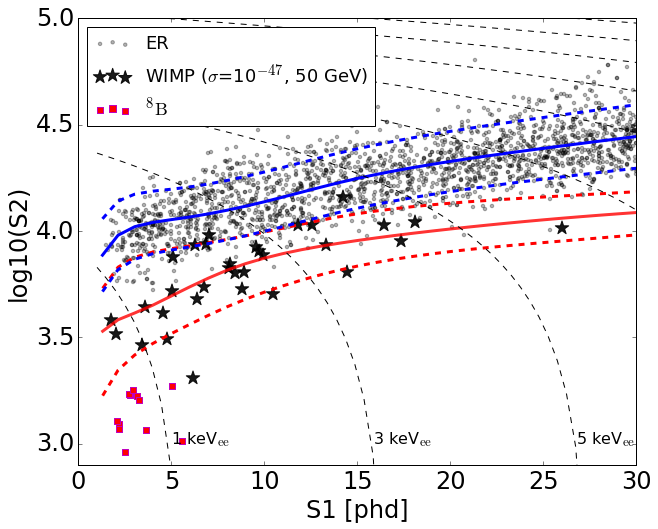

In [76]:
#search below 50% NR mean and from 3 to 20 PE (1.5 to 6.5 keVee with g1=0.075)
S1_min=1
S1_max=50
S2raw_min=450 #about 5 electrons
title='mW50-sig-1e47-'


#plot NR band
plot(S1_bin_cen_n,sNR(S1_bin_cen_n)+log10(S1_bin_cen_n),'-r',linewidth=3,alpha=0.8)
s = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n, s=.01)
s_ub = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n+1.28*std_S2oS1_n, s=.01) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n-1.28*std_S2oS1_n, s=.01)
plot(S1_bin_cen_n,s_ub(S1_bin_cen_n)+log10(S1_bin_cen_n),'--r',linewidth=3)
plot(S1_bin_cen_n,s_lb(S1_bin_cen_n)+log10(S1_bin_cen_n),'--r',linewidth=3)

#plot ER band, with a smooth spline
s = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e, s=.01)
s_ub = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e+1.28*std_S2oS1_e, s=.01) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e-1.28*std_S2oS1_e, s=.01)
plot(S1_bin_cen_e,s(S1_bin_cen_e)+log10(S1_bin_cen_e),'-b',linewidth=3)
plot(S1_bin_cen_e,s_ub(S1_bin_cen_e)+log10(S1_bin_cen_e),'--b',linewidth=3)
plot(S1_bin_cen_e,s_lb(S1_bin_cen_e)+log10(S1_bin_cen_e),'--b',linewidth=3)

plt.scatter(S1_er[WS_cut_er],log10(S2_er[WS_cut_er]),color='k',s=12,alpha=0.3,edgecolor='k',label='ER'\
            ,facecolor='k')
#plt.scatter(S1_Rn[WS_cut_rn],log10(S2_Rn[WS_cut_rn]/S1_Rn[WS_cut_rn]),color='magenta',s=10,alpha=0.3,label='ER')
#plt.scatter(S1_pp[WS_cut_pp],log10(S2_pp[WS_cut_pp]/S1_pp[WS_cut_pp]),color='blue',s=15,alpha=0.3,label='PP Solar',marker='^',edgecolor='b',linewidths=1)

matplotlib.mathtext.SHRINK_FACTOR = 0.8
plt.scatter(S1_mw50[WS_cut_wmp],log10(S2_mw50[WS_cut_wmp]),s=200\
            ,color="k", alpha=0.9, edgecolor='k', marker='*',label=r'WIMP ($\rm{\sigma}$=10$\rm{^{-47}}$, 50 GeV)')

plt.scatter(S1_cnns[WS_cut_cnns],log10(S2_cnns[WS_cut_cnns]),\
            color='red',s=40,alpha=1,marker='s',label=r'$\rm{^8B}$',edgecolor='m')
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2)')

#plt.plot([S1_min,S1_min],[2,3.8],'-.m',linewidth=4)
#plt.plot([S1_max,S1_max],[2,3.8],'-.m',linewidth=4)

#plot NR mean, with a smooth spline, and calculate number of WS candidates
#sNR = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n)
#WS_under_NRmean= sum((log10(S2[WS_cut]/S1[WS_cut])<=sNR(S1[WS_cut])) ) 
#WS_above_NRmean= sum((log10(S2[WS_cut]/S1[WS_cut])>sNR(S1[WS_cut])) )



#threshold line
s1_t=np.linspace(1,10,100)
s2s1_t=log10(S2raw_min/s1_t)
#plt.plot(s1_t,s2s1_t,'--k')

#energy contours
s1_e=np.linspace(1,50,100)
for en in range(1,20,2):
    s2_e=113*(en*73-s1_e/0.075) #113=g2
    plot(s1_e,log10(s2_e),'--k')
    s2s1=log10(s2_e)
    if en <6:
        index=int32(np.where(s2s1<=3.0)[0][0])
        matplotlib.mathtext.SHRINK_FACTOR = 0.8
        plt.text(s1_e[index],3.00,str(en)+' keV'+r'$\mathrm{_{ee}}$',fontsize=16)

plt.legend(fontsize=18,numpoints=1,loc='upper left',frameon = 1,framealpha=1)

#plt.xscale('log')
xlim([0,30])
ylim([2.9,5.0])
savefig('figs/'+title+'_1LZ_Stairs.pdf')
savefig('figs/'+title+'_1LZ_Stairs.png')

<h1> 1D Projection </h1>

In [86]:
#search below 50% NR mean and from 3 to 20 PE (1.5 to 6.5 keVee with g1=0.075)
S1_min=0
S1_max=20
S2raw_min=450 #about 5 electrons
title='Discrim-1D'

#define combined cnns signal
S1_cnns=np.hstack([S1_b8,S1_atm,S1_hep,S1_dsn])
S2_cnns=np.hstack([S2_b8,S2_atm,S2_hep,S2_dsn])
S2_cnns_raw=np.hstack([S2_b8_raw,S2_atm_raw,S2_hep_raw,S2_dsn_raw])
S1_er=np.hstack([S1_pp,S1_Rn,S1_Rn220])
S2_er=np.hstack([S2_pp,S2_Rn,S2_Rn220])
S2_er_raw=np.hstack([S2_pp_raw,S2_Rn_raw,S2_Rn220_raw])

#make cuts to plot Rn, PP, cnns and 50 GeV WIMP signal
WS_cut_rn=(inrange(S1_Rn,[S1_min,S1_max])) & (S2_Rn_raw>=S2raw_min)
WS_cut_pp=(inrange(S1_pp,[S1_min,S1_max])) & (S2_pp_raw>=S2raw_min)
WS_cut_cnns=(inrange(S1_cnns,[S1_min,S1_max])) & (S2_cnns_raw>=S2raw_min)
WS_cut_er=(inrange(S1_er,[S1_min,S1_max])) & (S2_er_raw>=S2raw_min)
WS_cut_wmp=(inrange(S1_mw50,[S1_min,S1_max])) & (S2_mw50_raw>=S2raw_min)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


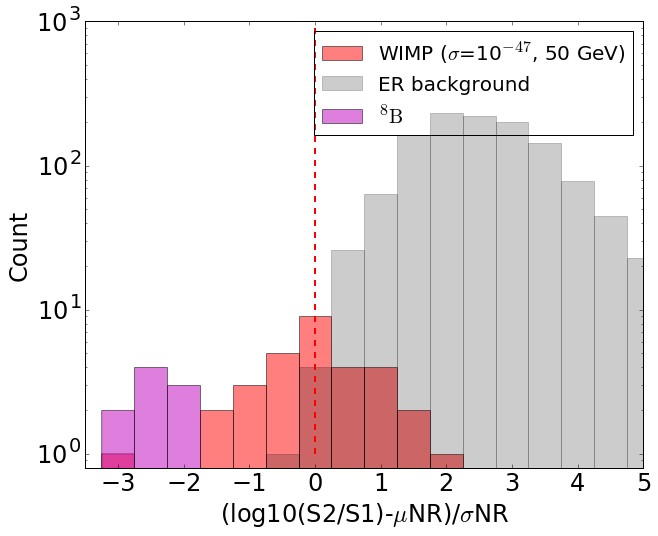

In [104]:
#interpolate the NR sigma (already have the mean as sNR)
sNR_sig = ip.UnivariateSpline(S1_bin_cen_n, std_S2oS1_n, s=.001) #1.28 sigma for 10-90% bands

fm_WIMP=(log10(S2_mw50[WS_cut_wmp]/S1_mw50[WS_cut_wmp])-sNR(S1_mw50[WS_cut_wmp]))/sNR_sig(S1_mw50[WS_cut_wmp])
fm_er=(log10(S2_er[WS_cut_er]/S1_er[WS_cut_er])-sNR(S1_er[WS_cut_er]))/sNR_sig(S1_er[WS_cut_er])
fm_cnns=(log10(S2_cnns[WS_cut_cnns]/S1_cnns[WS_cut_cnns])-sNR(S1_cnns[WS_cut_cnns]))/sNR_sig(S1_cnns[WS_cut_cnns])

xbins=np.arange(-3.25,7.25,0.5)

hist(fm_WIMP,bins=xbins,normed=0,alpha=0.5,color='r',label=r'WIMP ($\rm{\sigma}$=10$\rm{^{-47}}$, 50 GeV)')
hist(fm_er,bins=xbins, normed=0,alpha=0.2,color='k',label='ER background')
hist(fm_cnns,bins=xbins,normed=0,alpha=0.5,color='m',label=r'$\rm{^8B}$')
yscale('log')
legend(loc='upper right',fontsize=20)
xlabel('(log10(S2/S1)-'+r'$\mu$'+'NR)/'+r'$\sigma$NR')
ylabel('Count')

ylim([0.8,1000])
xlim([-3.5,5])

plot([0,0],[1,1000],'--r',linewidth=2)

savefig('figs/'+title+'_1LZ-1D.pdf')
savefig('figs/'+title+'_1LZ-1D.png')

<h1> High stats version of histogram</h1>

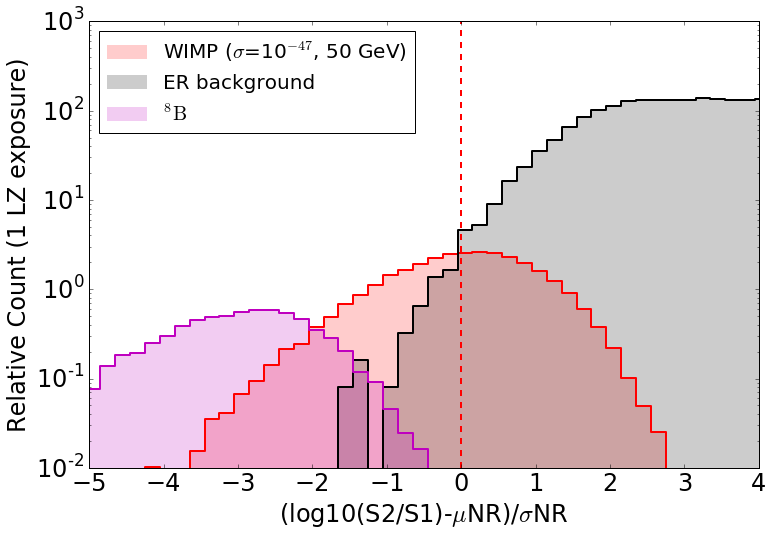

In [137]:
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"

title='Discrim-1D'
#interpolate the NR sigma (already have the mean as sNR)
sNR_sig = ip.UnivariateSpline(S1_bin_cen_n, std_S2oS1_n, s=.001) #1.28 sigma for 10-90% bands

fm_WIMP=(log10(S2_cut_mw50/S1_cut_mw50)-sNR(S1_cut_mw50))/sNR_sig(S1_cut_mw50)
fm_er=(log10(S2_cut_er/S1_cut_er)-sNR(S1_cut_er))/sNR_sig(S1_cut_er)
fm_cnns=(log10(S2_cut_b8/S1_cut_b8)-sNR(S1_cut_b8))/sNR_sig(S1_cut_b8)

width=0.2
xbins=np.arange(-5.25,7.25,width)

val, edges = histogram(fm_WIMP,bins=xbins,normed=0) 
bin_cen= (edges[1:]+edges[:-1])/2
plt.bar(edges[:-1], val*1/mw50_exp_sig47 ,width=width,alpha=0.2, color='r',edgecolor ='r',linewidth =0, \
        label=r'WIMP ($\rm{\sigma}$=10$\rm{^{-47}}$, 50 GeV)')
plt.step(edges[1:],val*1/mw50_exp_sig47,color='r',linewidth=2)
#madness... plt.bar wants left edges and plt.step wants right edges :/

val, edges = histogram(fm_er,bins=xbins, normed=0) 
bin_cen= (edges[:-1]+edges[1:])/2
plt.bar(edges[:-1],val*1/er_exp ,width=width,alpha=0.2,color='k',linewidth =0,label='ER background')
plt.step(edges[1:],val*1/er_exp,color='k',linewidth=2)

val, edges = histogram(fm_cnns,bins=xbins,normed=0) 
bin_cen= (edges[:-1]+edges[1:])/2
plt.bar(edges[:-1],val*1/b8_exp ,width=width,alpha=0.2,color='m',linewidth =0,label=r'$\rm{^8B}$')
plt.step(edges[1:],val*1/b8_exp,color='m',linewidth=2)

yscale('log')
legend(fontsize=20,loc='upper left')
xlabel('(log10(S2/S1)-'+r'$\mu$'+'NR)/'+r'$\sigma$NR')
ylabel('Relative Count (1 LZ exposure)')

ylim([0.01,1000])
xlim([-5,4])

plot([0,0],[0.01,1000],'--r',linewidth=2)


savefig('figs/'+title+'_1LZnorm-1D.pdf')
savefig('figs/'+title+'_1LZnorm-1D.png')

<h1> Luck Plot 2 </h1>

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:55: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:56: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:58: RuntimeWarning: invalid value encountered in less_equal


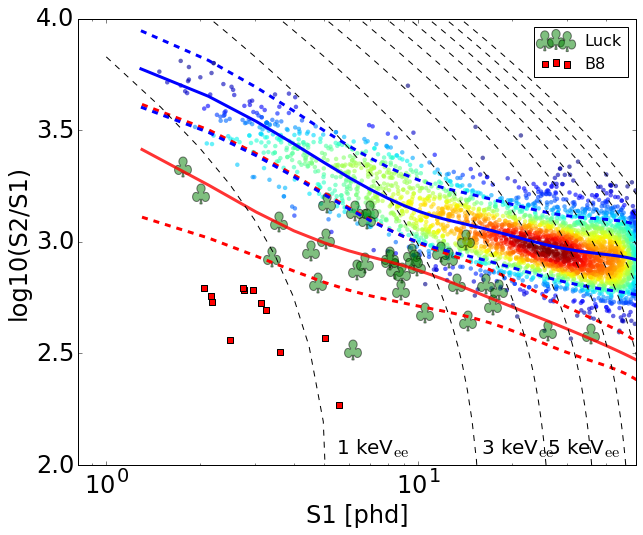

In [79]:
#search below 50% NR mean and from 3 to 20 PE (1.5 to 6.5 keVee with g1=0.075)
S1_min=1
S1_max=50
S2raw_min=450 #about 5 electrons
title='mW50-sig-1e47-'
#define combined cnns signal
S1_cnns=np.hstack([S1_b8,S1_atm,S1_hep,S1_dsn])
S2_cnns=np.hstack([S2_b8,S2_atm,S2_hep,S2_dsn])
S2_cnns_raw=np.hstack([S2_b8_raw,S2_atm_raw,S2_hep_raw,S2_dsn_raw])
S1_er=np.hstack([S1_pp,S1_Rn,S1_Rn220])
S2_er=np.hstack([S2_pp,S2_Rn,S2_Rn220])
S2_er_raw=np.hstack([S2_pp_raw,S2_Rn_raw,S2_Rn220_raw])

#make cuts to plot Rn, PP, cnns and 50 GeV WIMP signal
WS_cut_rn=(inrange(S1_Rn,[S1_min,S1_max])) & (S2_Rn_raw>=S2raw_min)
WS_cut_pp=(inrange(S1_pp,[S1_min,S1_max])) & (S2_pp_raw>=S2raw_min)
WS_cut_cnns=(inrange(S1_cnns,[S1_min,S1_max])) & (S2_cnns_raw>=S2raw_min)
WS_cut_er=(inrange(S1_er,[S1_min,S1_max])) & (S2_er_raw>=S2raw_min)
WS_cut_wmp=(inrange(S1_mw50,[S1_min,S1_max])) & (S2_mw50_raw>=S2raw_min)


#plot NR band
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=3,alpha=0.8)
s = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n, s=.01)
s_ub = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n+1.28*std_S2oS1_n, s=.01) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n-1.28*std_S2oS1_n, s=.01)
plot(S1_bin_cen_n,s_ub(S1_bin_cen_n),'--r',linewidth=3)
plot(S1_bin_cen_n,s_lb(S1_bin_cen_n),'--r',linewidth=3)

#plot ER band, with a smooth spline
s = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e, s=.01)
s_ub = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e+1.28*std_S2oS1_e, s=.01) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bin_cen_e, mean_S2oS1_e-1.28*std_S2oS1_e, s=.01)
plot(S1_bin_cen_e,s(S1_bin_cen_e),'-b',linewidth=3)
plot(S1_bin_cen_e,s_ub(S1_bin_cen_e),'--b',linewidth=3)
plot(S1_bin_cen_e,s_lb(S1_bin_cen_e),'--b',linewidth=3)


scatterColor(S1_er[WS_cut_er],log10(S2_er[WS_cut_er]/S1_er[WS_cut_er]),a=0.6,size=20)

plt.scatter(S1_mw50[WS_cut_wmp],log10(S2_mw50[WS_cut_wmp]/S1_mw50[WS_cut_wmp]),s=400,\
            color="g", alpha=0.5, edgecolor='k', marker=r'$\clubsuit$',label="Luck") #,label='WIMP (1e-47, 50 GeV)'
plt.scatter(S1_cnns[WS_cut_cnns],log10(S2_cnns[WS_cut_cnns]/S1_cnns[WS_cut_cnns]),\
            color='red',s=40,alpha=1,marker='s',label='B8',edgecolor='k')


#threshold line
s1_t=np.linspace(1,10,100)
s2s1_t=log10(S2raw_min/s1_t)
#plt.plot(s1_t,s2s1_t,'--k')

#energy contours

s1_e=np.linspace(1,50,100)
for en in range(1,20,2):
    s2_e=113*(en*73-s1_e/0.075) #113=g2
    plot(s1_e,log10(s2_e/s1_e),'--k')
    s2s1=log10(s2_e/s1_e)
    if en <7:
        index=int32(np.where(s2s1<=2.0)[0][0])
        matplotlib.mathtext.SHRINK_FACTOR = 0.8
        plt.text(s1_e[index],2.05,str(en)+' keV'+r'$\mathrm{_{ee}}$',fontsize=20)

plt.legend(fontsize=16,numpoints=1)
plt.xscale('log')
xlim([0,50])
ylim([2.0,4.0])

plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')

savefig('figs/'+title+'_1LZ-Luck-log.pdf')
savefig('figs/'+title+'_1LZ-Luck-log.png')


<h1> Draw n-sigma contorus around population </h1>

In [2]:
import numpy
import scipy
import scipy.stats
#import matplotlib.pyplot as plt

# generate two normally distributed 2d arrays
x1=numpy.random.multivariate_normal((100,420),[[120,80],[80,80]],400)
x2=numpy.random.multivariate_normal((140,340),[[90,-70],[-70,80]],400)

# fit a KDE to the data
pdf1=scipy.stats.kde.gaussian_kde(x1.T)
pdf2=scipy.stats.kde.gaussian_kde(x2.T)

# create a grid over which we can evaluate pdf
q,w=numpy.meshgrid(range(50,200,10), range(300,500,10))
r1=pdf1([q.flatten(),w.flatten()])
r2=pdf2([q.flatten(),w.flatten()])

# sample the pdf and find the value at the 95th percentile
s1_2=scipy.stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 5)
s1_1=scipy.stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 100-68.26)
s2=scipy.stats.scoreatpercentile(pdf2(pdf2.resample(1000)), 5)

# reshape back to 2d
r1.shape=(20,15)
r2.shape=(20,15)

# plot the contour at the 95th percentile
plt.contourf(range(50,200,10), range(300,500,10), r1, [s1_2,s1_1],colors='b')
plt.contourf(range(50,200,10), range(300,500,10), r1, [s1_1,0],colors='c')
plt.contour(range(50,200,10), range(300,500,10), r2, [s2],colors='r')

# scatter plot the two normal distributions
plt.scatter(x1[:,0],x1[:,1],alpha=0.3)
plt.scatter(x2[:,0],x2[:,1],c='r',alpha=0.3)

NameError: name 'plt' is not defined

In [112]:
if isinstance([0],list):
    print('yes')

yes


In [15]:
def pdfcont(x,y,nsig=3,color='b',fill=True,fill_alpha=0.2, colormap=plt.cm.Reds, xlim=-1, ylim=-1,bins=50,label=True):
    # fit a KDE to the data
    if isinstance(xlim,list):
        xmin=xlim[0]
        xmax=xlim[1]
    else:
        xmin=min(x)
        xmax=max(x)
    if isinstance(ylim,list):
        ymin=ylim[0]
        ymax=ylim[1]
    else:
        ymin=min(y)
        ymax=max(y)
    
    x_range=linspace(xmin,xmax,bins)
    y_range=linspace(ymin,ymax,bins)
    pdf1=stats.kde.gaussian_kde([x,y])
    # create a grid over which we can evaluate pdf
    q,w=np.meshgrid(x_range, y_range)
    r1=pdf1([q.flatten(),w.flatten()])
    # sample the pdf and find the value at the 95th percentile
    sig3=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 0.3)
    sig2=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 5)
    sig1=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 100-68.26)
    per50=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 50)
    per0=stats.scoreatpercentile(pdf1(pdf1.resample(1000)), 100)
    # reshape back to 2d
    r1.shape=(size(y_range),size(x_range))

    levels=[sig1,sig2,sig3][:nsig]
    # plot the contour at the 95th percentile
    
    CS=plt.contour(x_range, y_range, r1, levels,linewidths=3,alpha=1,colors=color, linestyles=['-','--']) #
    #plt.contour(x_range, y_range, r1, [sig2],colors='c',linewidths=2)
    #c1=plt.contour(x_range, y_range, r1, [sig1],colors='r',use_clabeltext=True)
    # Recast levels to new class
    CS.levels = ['1$\sigma$','2$\sigma$','3$\sigma$'][:nsig]

    #plt.contourf(x_range, y_range, r1,[sig1,per0] ,linewidths=1,alpha=0.5)
    if fill==True:
        levels.reverse()
        levels.append(per0)
        plt.contourf(x_range, y_range, r1,levels ,linewidths=1,alpha=fill_alpha,cmap=colormap)
    # Label levels with specially formatted floats
    #if plt.rcParams["text.usetex"]:
    #    fmt = r'%r \%%'
    #else:
    #    fmt = '%1.3f %%'
    #    fmt = '%{:} %%'
    if label==True:
        plt.clabel(CS, CS.levels, inline=True, fontsize=20)
    
#input x,y range in the future for selected region 
def pdf_gen(x_var,y_var,x_range_sel,y_range_sel,nbins = 100):
    x_var=np.array(x_var) #first convert to np array for logical cuts
    y_var=np.array(y_var)
    cut= (x_var>=x_range_sel[0]) & (x_var<=x_range_sel[1]) & (y_var>=y_range_sel[0]) & (y_var<=y_range_sel[1])
    x_var=x_var[cut]
    y_var=y_var[cut]
    
    H, xedges, yedges = histogram2d(x_var,y_var, bins=nbins,normed=1)
    H=H.T
    xcenters = xedges[:-1] + diff(xedges[:2])/2
    ycenters = yedges[:-1] + diff(yedges[:2])/2
    #Construct interpolator
    pdf = interp2d(xcenters, ycenters, H, kind='linear')
    x_r=[xedges.min(),xedges.max()]
    y_r=[yedges.min(),yedges.max()]
    
    x_range=linspace(x_range_sel[0],x_range_sel[1],nbins)
    y_range=linspace(y_range_sel[0],y_range_sel[1],nbins)
    # fit a KDE to the data
    pdf=sp.stats.kde.gaussian_kde([x_var,y_var])
    q,w=np.meshgrid(x_range, y_range)
    r1=pdf([q.flatten(),w.flatten()])
    r1.shape=(size(y_range),size(x_range))
    r1=r1/sum(r1) #normalize the pdf
    return r1, x_var, y_var, x_range, y_range

def interpAD(Z,X,Y):
    vals=[]
    for x,y in zip (X,Y):
        vals.append(Z(x,y)[0])
    return np.array(vals)

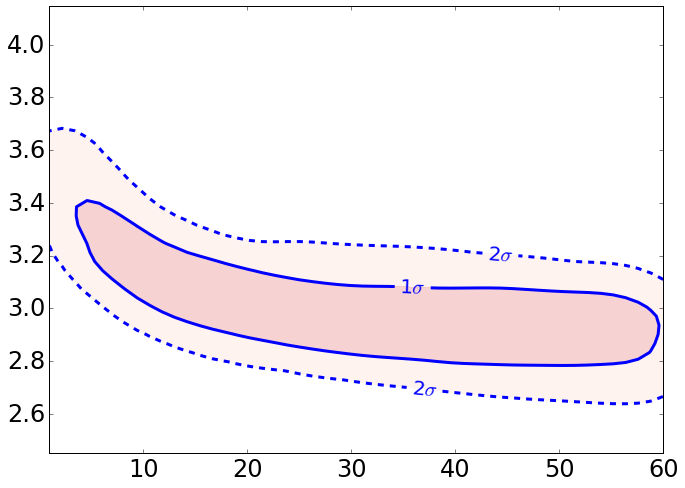

In [175]:
pdfcont(S1_cut_er,log10(S2_cut_er/S1_cut_er),nsig=2,bins=50)

In [14]:
x1=numpy.random.multivariate_normal((100,420),[[120,80],[80,80]],400)
shape(x1)

(400, 2)